<center><img src="./images/rtu_logo_lv.png" alt="RTU" title="RTU" width="150em"/></center>

<center><b>RĪGAS TEHNISKĀ UNIVERSITĀTE</b></center>
<center><b>DATORZINĀTNES UN INFORMĀCIJAS TEHNOLOĢIJAS FAKULTĀTE</b></center>
<center><b>Priekšmeta "Ievads mākslīgos neironu tīklos"</b></center><center>

<center><b>2. mājasdarbs</b></center>

<div style="text-align: right">
    LDsI 12300 Lietišķo datorsistēmu institūts<br>
    RDBD0 Datorsistēmas<br>
    <b>3. kursa 3. grupas</b> pilna laika klātienes <b>students</b><br>
    Oļegs Korsaks<br>
    <b>Studenta apliecības Nr.: </b>051RDB146<br>
</div>
<center><b>Rīga, 2021</b></center>
<div style="display:none">\pagebreak</div>

***

## Saturs

* [Risināma uzdevuma nostādne](#Risināma-uzdevuma-nostādne-)
    * [Datu kopas apraksts](#Datu-kopas-apraksts)
    * [Veicamā uzdevuma būtība](#Veicamā-uzdevuma-būtība)
* [Eksperimentu mērķis un plāns](#Eksperimentu-mērķis-un-plāns)
* [Datu ielāde](#Datu-ielāde)
    * [Datu analīze](#Datu-analīze)
* [Apmācības kļūdas konverģences novērošana iterācijām un iegūto rezultātu analīze](#Apmācības-kļūdas-konverģences-novērošana-iterācijām-un-iegūto-rezultātu-analīze)
    * [Lineāras regressijas metode](#Lineāras-regressijas-metode)
    * [Klasifikācijas metode](#Klasifikācijas-metode)
* [Secinājumi](#Secinājumi)

## Risināma uzdevuma nostādne <a class="anchor" id="chapter1"></a>

### Datu kopas apraksts

Paņemu vīna kvalitātes datus no https://archive.ics.uci.edu/ml/datasets/Wine+Quality

Izmantoju baltā vīna datus, jo tur ir 4898 ierakstu.

### Veicamā uzdevuma būtība

* Atrast datu kopu internetā. Piemēram no Awesomedata vai UCI Machine Learning Repository vai citur
    * Vēlams ar simtiem līdz tūkstošiem ierakstiem,
    * Vēlams desmitiem atribūtiem,
    * Skaitliskās vērtības atribūtos,
    * Ar mērķa klasi/klasēm, bet var arī nepārtraukta vērtība,
    * Dažām datu kopām var nebūt izvirzīta mērķa klase. Šādos gadījumos var izmantot vienu no atribūtiem par mērķa klasi (ja ir iespējams loģiski pamatot).
* Sadalīt datu kopu apmācības un testa kopās.
* Izveidot daudzslāņu mākslīgo neironu tīklu ar tensorflow un veikt apmācību.
* Aprēķināt un novērtēt apmācības un testa kopas kļūdu.
* Pamainīt tīkla konfigurāciju un novērtēt izmaiņu ietekmi
* Arhitektūru – slēpto slāņu skaits, neironu skaits slāņos,
* Aktivācijas funkcijas,
* Optimizācijas metodi.

## Eksperimentu mērķis un plāns

Izmēģināšu dažādas parametru kombinācijas, lai saprastu kā tie ietekmē precizitāti un kļūdu.

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)

        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2600)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%load_ext tensorboard

sns.set_context('notebook', font_scale=2.0)
sns.set_style('darkgrid')

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
EPOCHS = 2000
BATCH_SIZE = 16
TF_DEVICE = '/gpu:0' if gpus else '/cpu:0'

### Datu ielāde

In [3]:
data = pd.read_csv('data/winequality-white.csv', sep=';')

#### Datu analīze

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Visi ieraksti satur vērtības priekš visiem parametriem.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


## Datu vizualizācija un analīze

Paskatīsimies, vai ir dati, kuru vērtības ļoti atšķiras no vairuma.

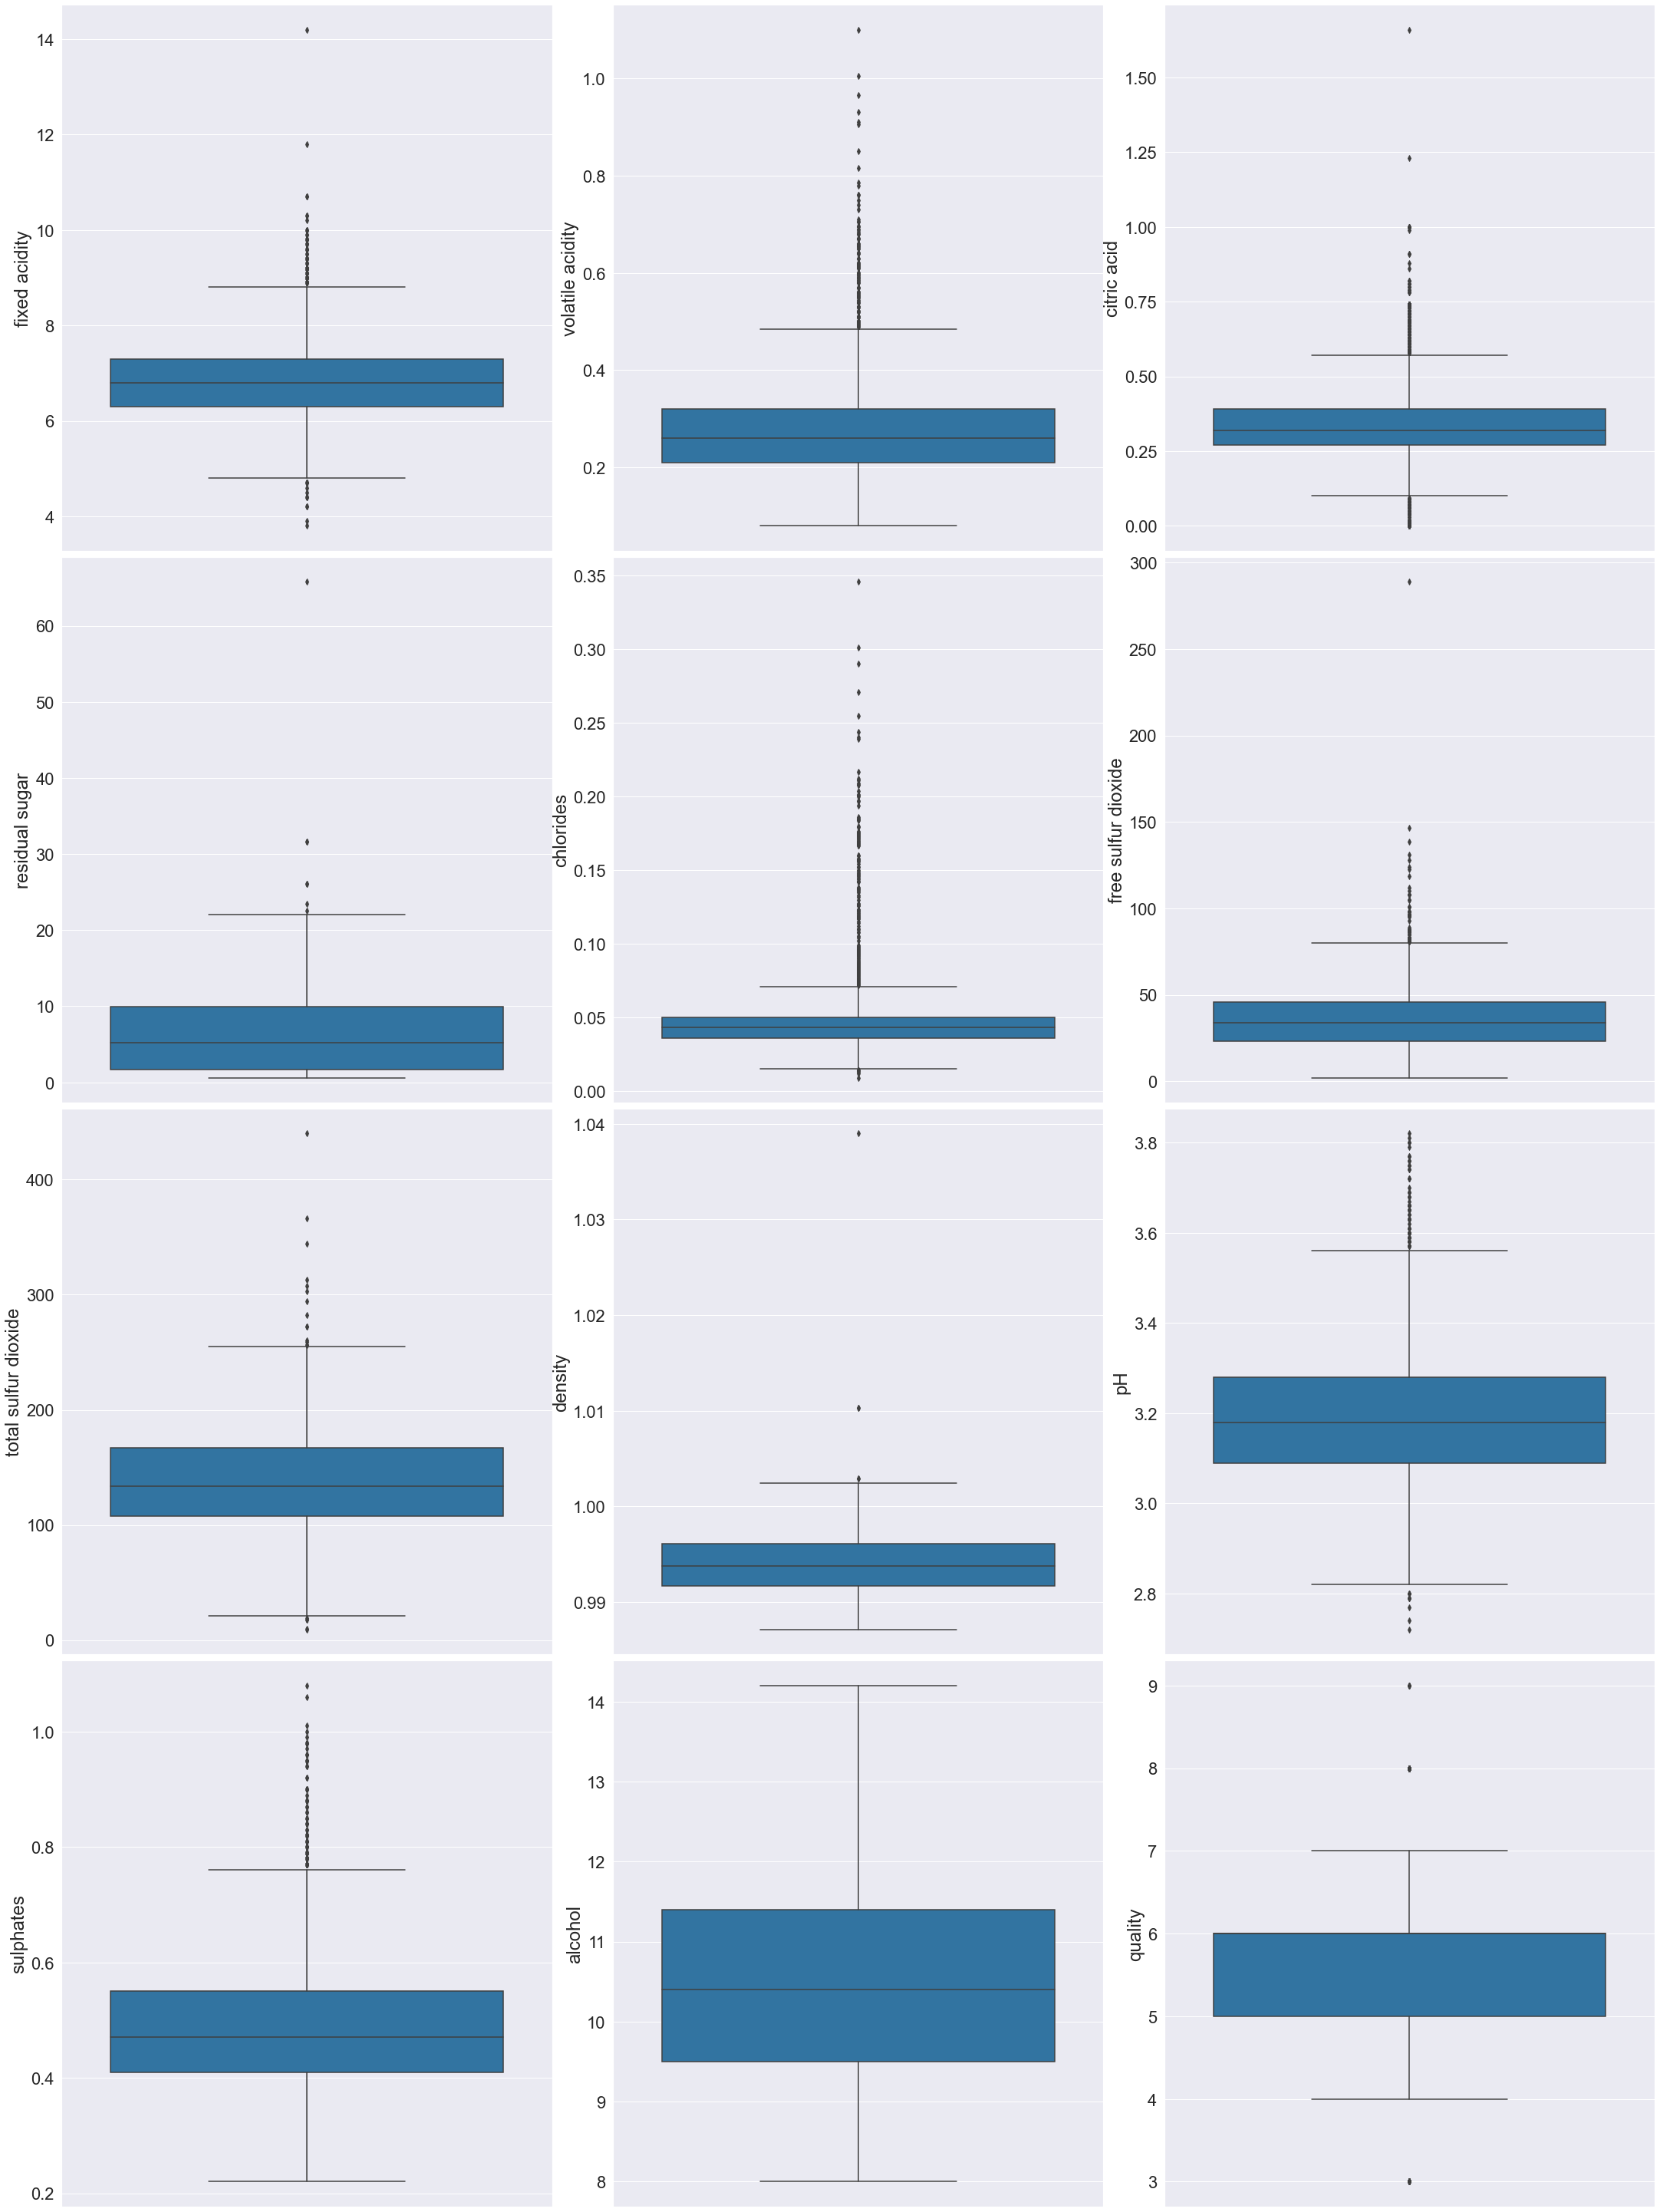

In [7]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.boxplot(y=col, data=data, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

Dažiem (piem. "total sulfur dioxide") ir tādas vērtības. Varbūt tie ietekmēs precizitāti.

Paskatīsimies uz vērtību sadali.

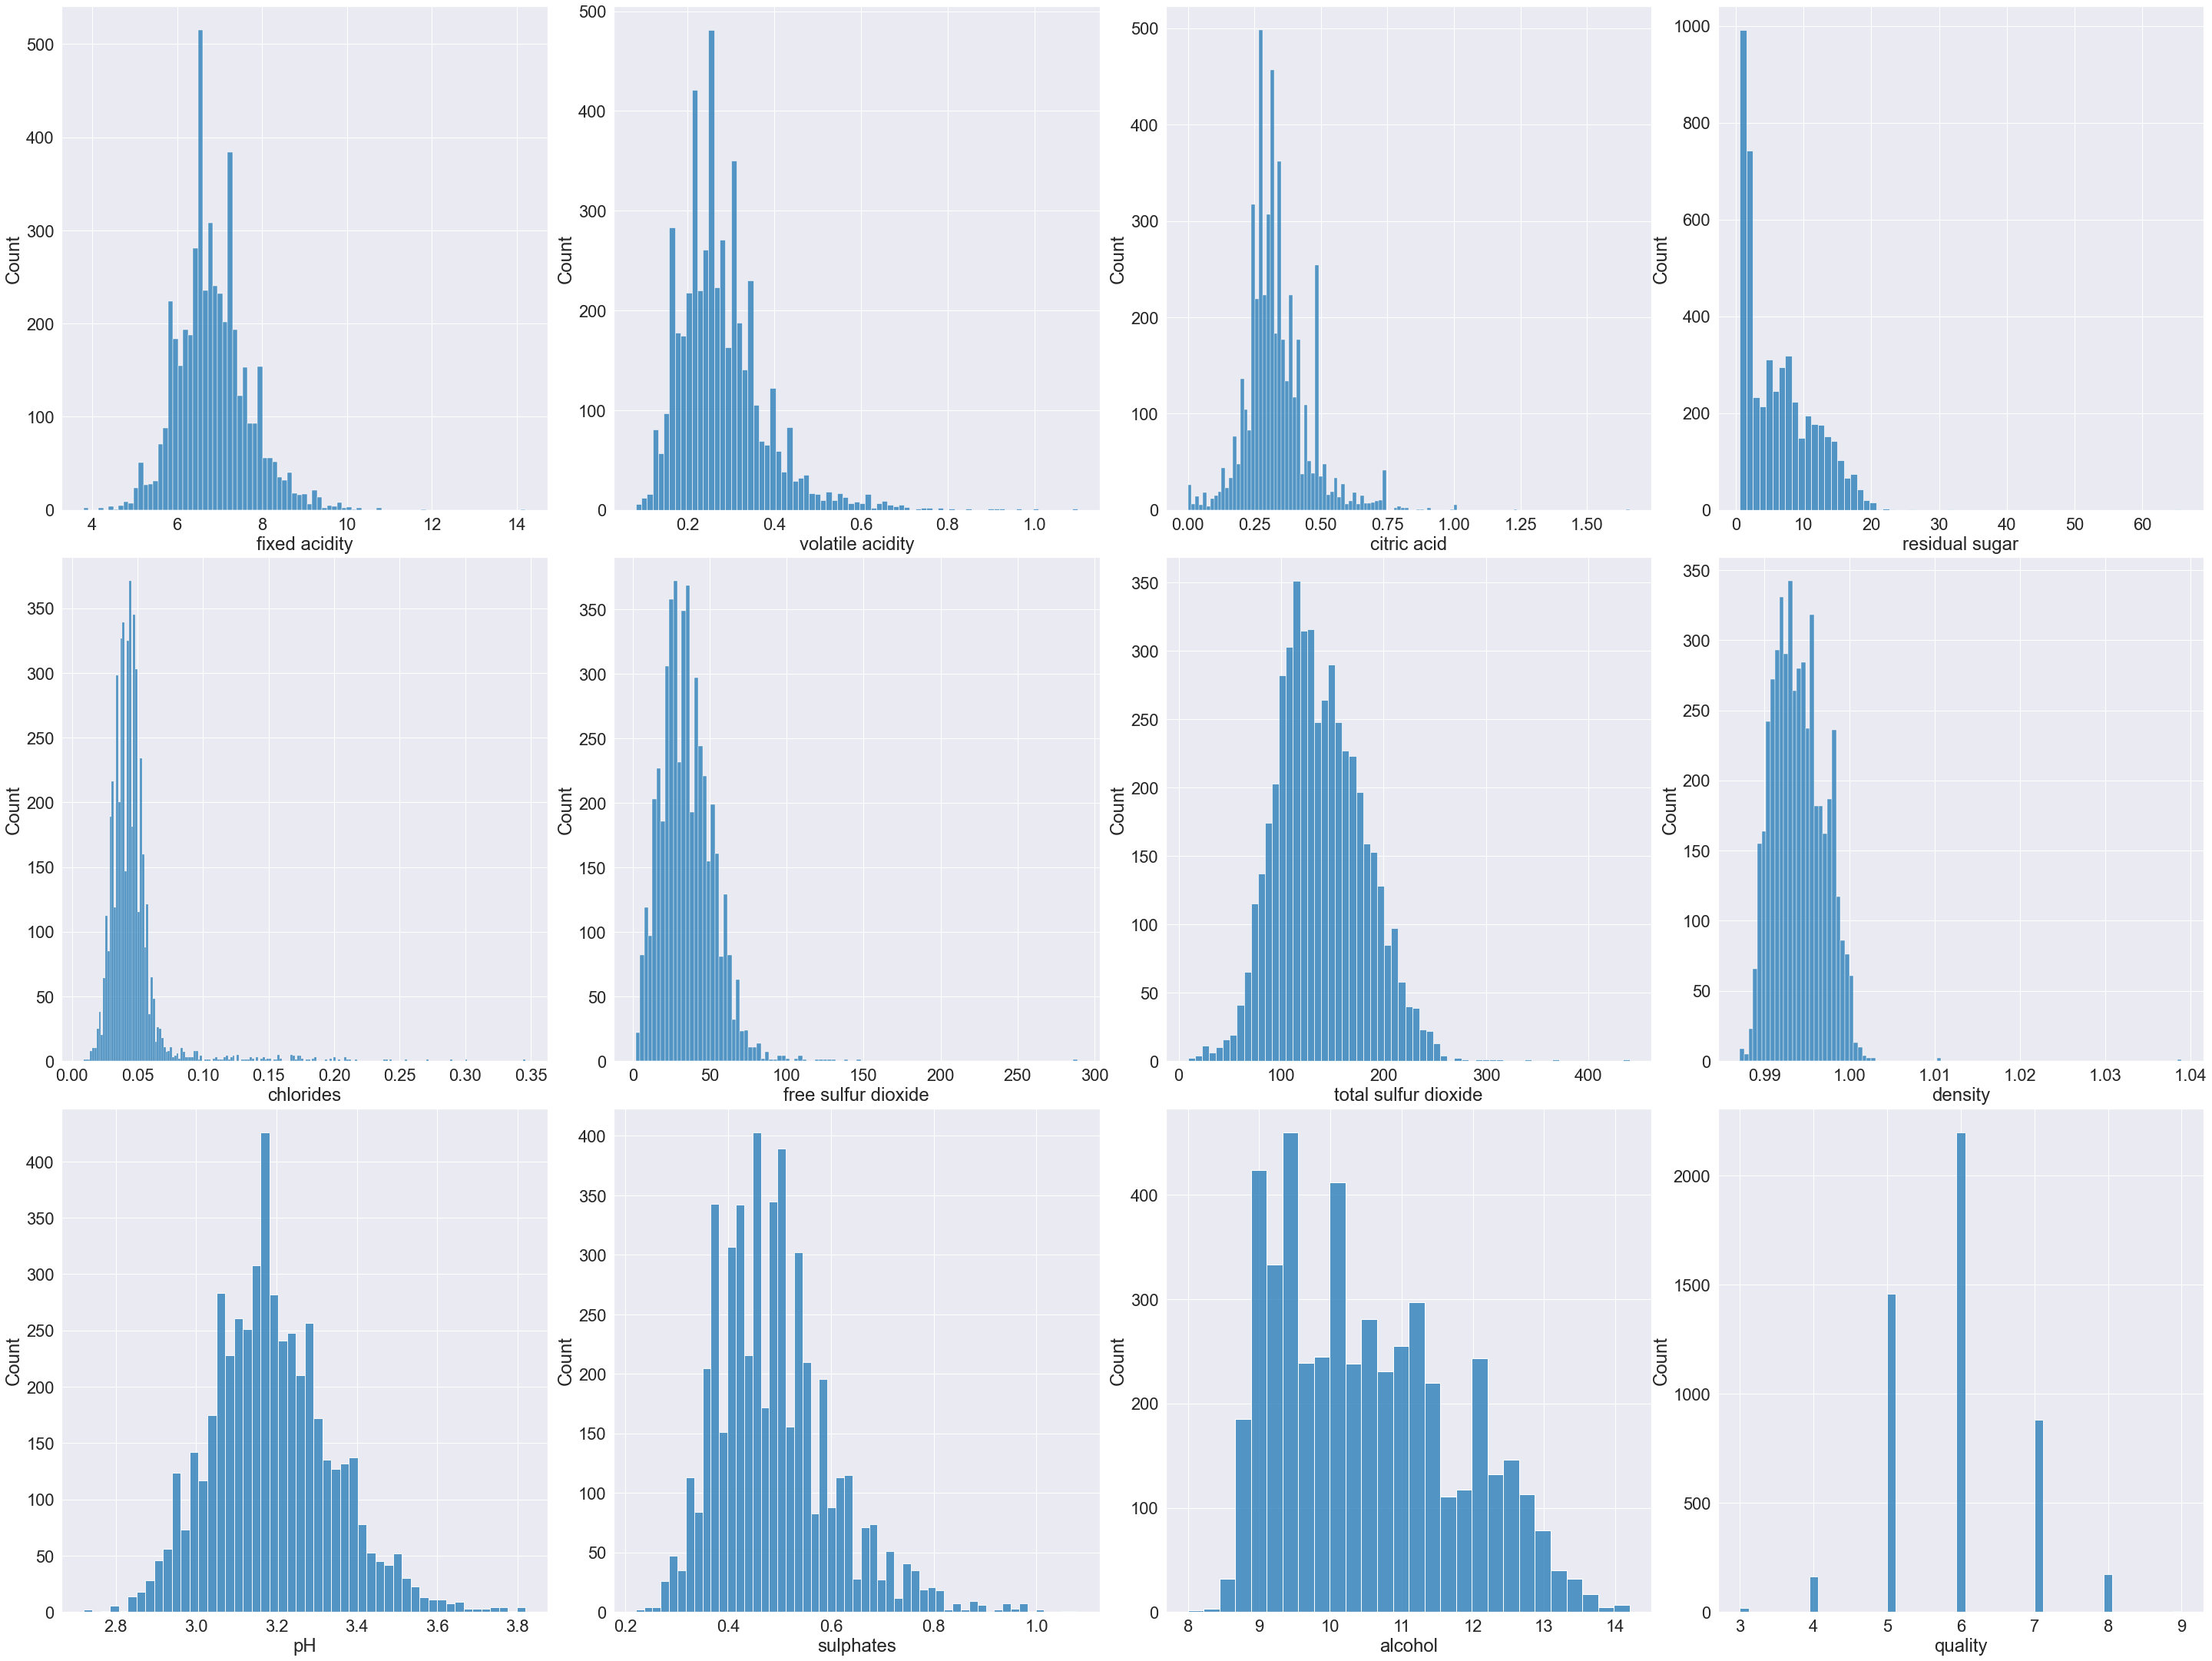

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(40, 30))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.histplot(value, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

Daži paramtetri satur ļoti lielas vērtības. Kā arī ne visi ir normālizēti.

<AxesSubplot:xlabel='quality', ylabel='count'>

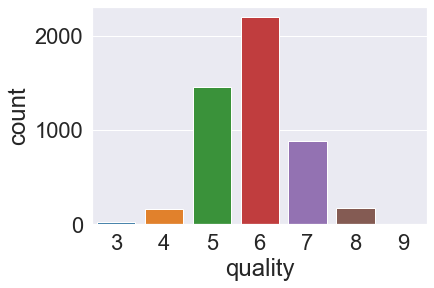

In [9]:
sns.countplot(x=data['quality'])

Mums pārsvārā ir vērtības 5, 6 un pat nav dažu vērtību vispār. Tāda klašu nelīdzsvarotība nozīmē, ka modelis varēs labi noklasificēt tikai 5. un 6. kvalitātes gadījumus.

### Paramtetru korelācija

<AxesSubplot:>

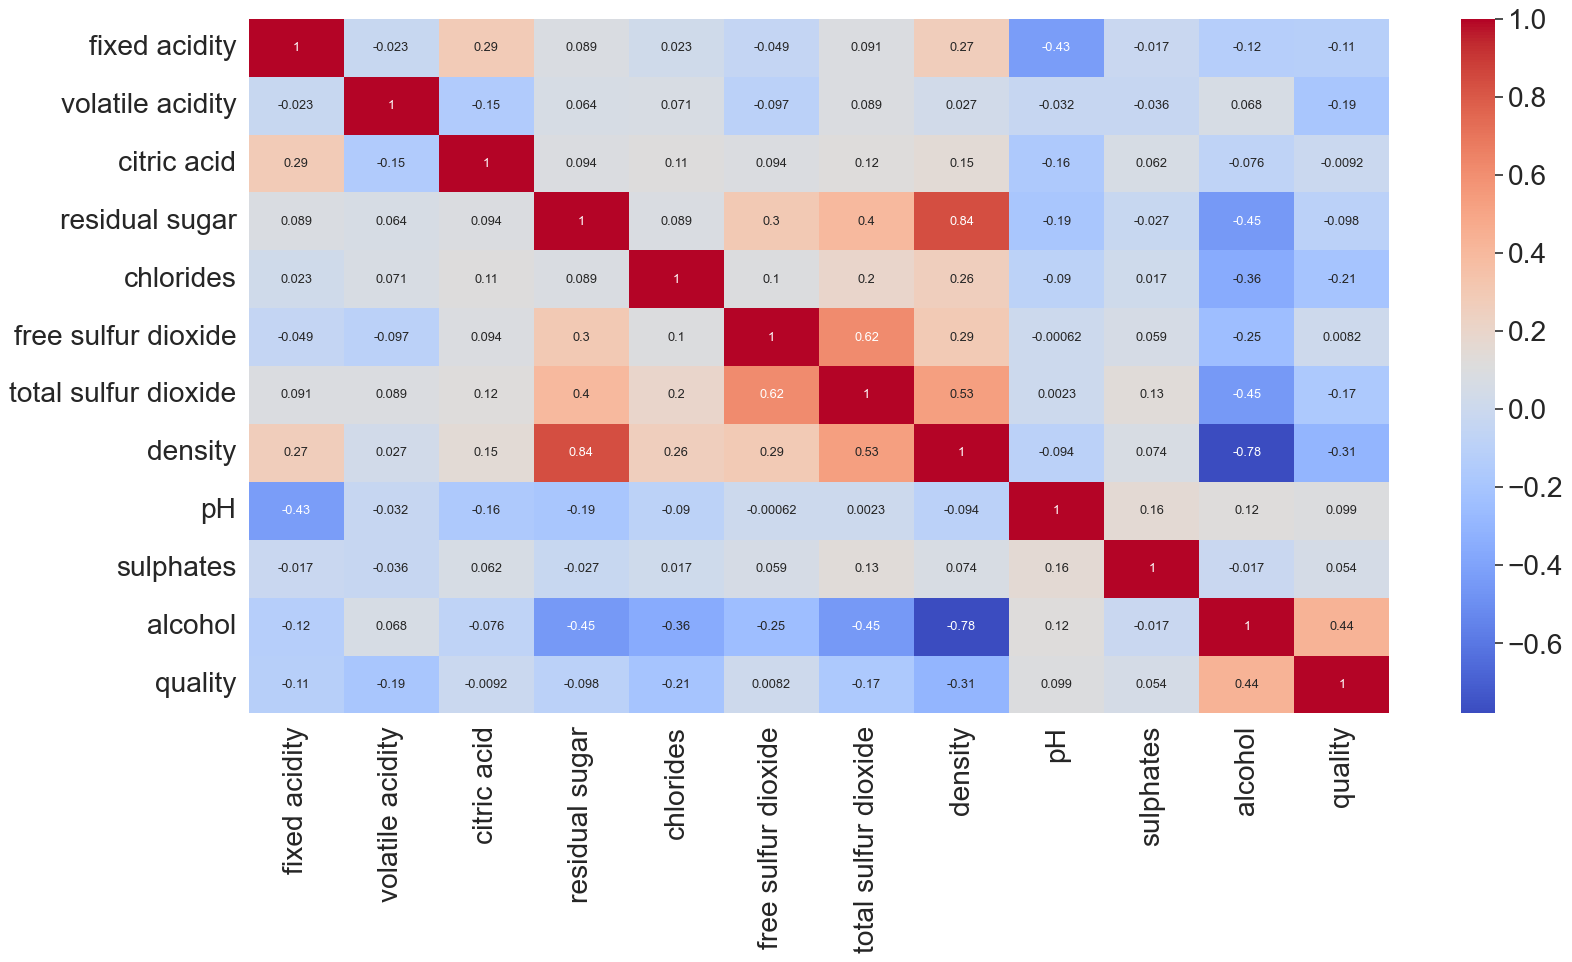

In [10]:
corr = data.corr()
plt.figure(figsize=(20, 10), dpi=92)
sns.heatmap(corr, annot=True, cmap='coolwarm')

Ir līdzīgi parametri tādi kā "free sulfur dioxide" in "total sulfur dioxide". Izskatas, ka viens ar otru pozitīvi korelē (jo viens ietiplst otrā). Bet kvalitāti tieši ietekmē tikai alkohols. Un pat tam ir vāja (0.3 - 0.5) korelācija ar kvalitāti. Izskatas, ka paņemu ne tik labus datus un kvalitāte tika noteikta ne no parametriem. Neskatoties uz pazaudēto nedēļu (ne tik ātri sapratu, kāpēc nav tik liela precizitāte) taisīšu uzdevumus ar visu šo, jo noteikt kļūdu var vienalga.

Atdalīsim kvalitāti atsevišķā kopā.

In [11]:
samples = data.copy()
qualities = samples.pop('quality')

In [12]:
attr_count = len(samples.keys())
print(attr_count, len(qualities.value_counts()))

11 7


Mums ir 11 atribūti un 7 klases, jo nav datu priekš citām klasēm.

## Apmācības kļūdas konverģences novērošana iterācijām un iegūto rezultātu analīze

## Lineāras regressijas metode

In [13]:
def plot_history(history):
    plt.figure(figsize=(18, 10), dpi=92)
    plt.plot(history.history['loss'])
    plt.plot(history.history[f'val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validate loss'], loc='best')
    plt.show()

In [14]:
def evaluate_model(model, samples, qualities, plot_fn, epochs=100, batch_size=BATCH_SIZE):
    samples_train, samples_test, qualities_train, qualities_test = train_test_split(samples,
                                                                                    qualities,
                                                                                    test_size=0.25,
                                                                                    shuffle=True)

    with tf.device(TF_DEVICE):
        # Let's try to force putting data into GPU memory when possible.
        samples_train = tf.constant(samples_train, dtype=tf.float64)
        samples_test = tf.constant(samples_test, dtype=tf.float64)
        qualities_train = tf.constant(np.asarray(list(qualities_train)).astype(np.int64), dtype=tf.int64)
        qualities_test = tf.constant(np.asarray(list(qualities_test)).astype(np.int64), dtype=tf.int64)

        log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


        try:
            history = model.fit(
                samples_train, qualities_train,
                validation_data=(samples_test, qualities_test),
                shuffle=False, epochs=epochs, batch_size=batch_size,
                verbose=0, callbacks=[tensorboard_callback]
            )
        except KeyboardInterrupt:
            raise
        else:
            plot_history(history)
        finally:
            evaluate_result = model.evaluate(samples_test, qualities_test, verbose=False)
            print(f'Test loss with default batch_size: {evaluate_result}')
            evaluate_result = model.evaluate(samples_test, qualities_test, batch_size=4096, verbose=False)
            print(f'Test loss with batch_size=4096: {evaluate_result}')

            predict_result = model.predict(samples_test)

            for sample_idx in (5, 7, 10, 20, 30, 50, -5, -7, -10, -20, -30, -50):
                print(f'Predicted: {predict_result[sample_idx]}, Expected: {qualities_test[sample_idx]}')

Savienošu ieejas signālus ar izejas slāni, paskatīsimies, vai tikai ar tiešiem svāriem būs pietiekams. Loss funkcija būs MSE (mean square error). Internetā atradu, ka optimizācijas algoritms Adadelta ir atrāks nekā Adam un pieļauj lielāko apmācības koeficentu bez problēmām.

In [15]:
def build_model(input_count: int):
    kreg = tf.keras.regularizers.l2(0.001)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(1, kernel_regularizer=kreg)
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.03)

    model.compile(loss='mse', optimizer=optimizer)

    return model

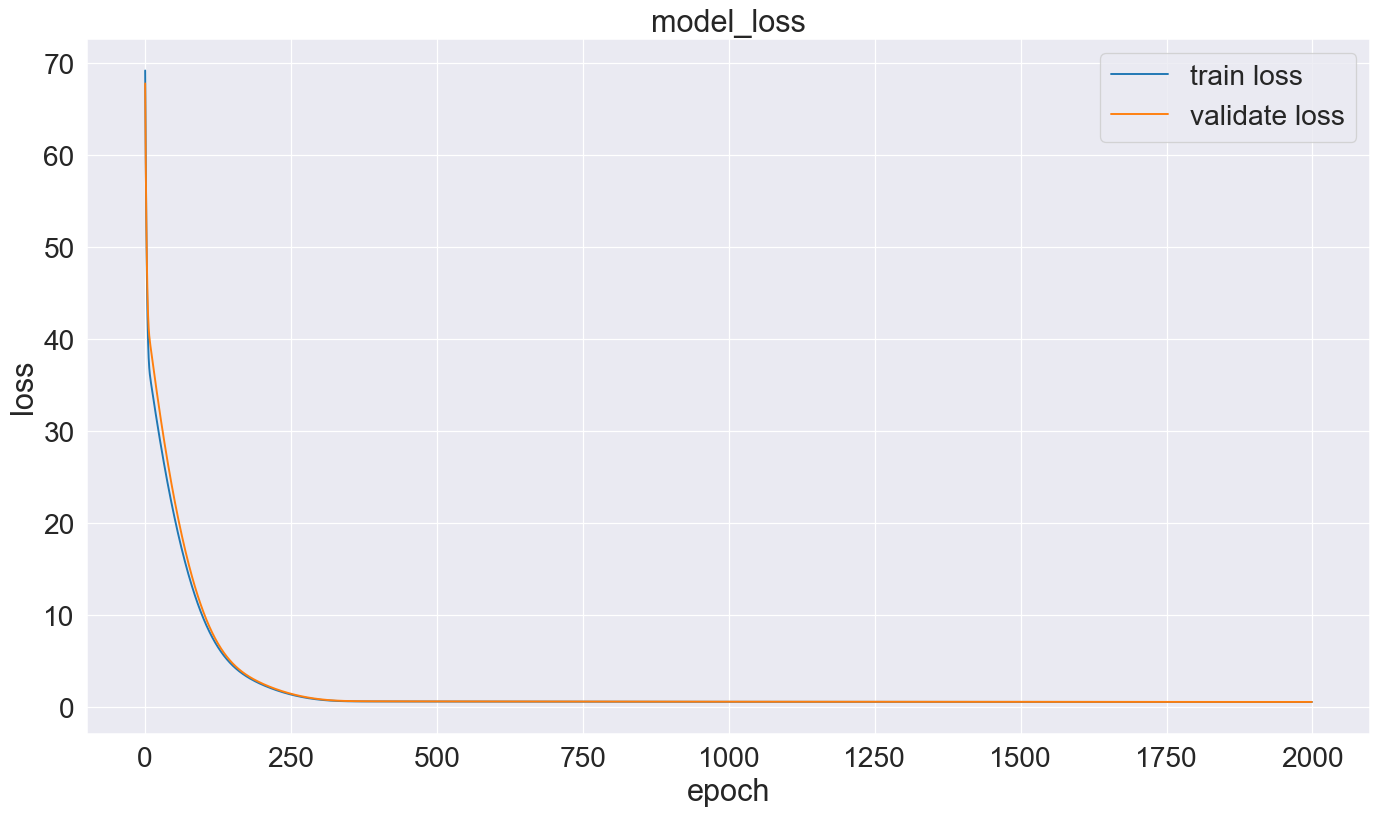

Test loss with default batch_size: 0.5872171521186829
Test loss with batch_size=4096: 0.5872171521186829
Predicted: [5.6082497], Expected: 7
Predicted: [6.39972], Expected: 7
Predicted: [5.4292126], Expected: 5
Predicted: [6.142283], Expected: 5
Predicted: [5.9661365], Expected: 6
Predicted: [5.1818767], Expected: 7
Predicted: [5.6445494], Expected: 5
Predicted: [6.4566216], Expected: 6
Predicted: [5.7989025], Expected: 5
Predicted: [5.523227], Expected: 5
Predicted: [6.205673], Expected: 7
Predicted: [6.5362], Expected: 7
Wall time: 4min 9s


In [16]:
%%time
model = build_model(attr_count)
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Nu vispār nav tik slikti priekš tukša tīkla. Pēc 2000 iterācijām MSE palika 0.587. Uzminet pareizo kvalitāti tomēr grūti. Pievienošu vienu slāni ar 11 neironiem un ReLU aktivācijas funkciju.

In [17]:
def build_model(input_count: int):
    kinit = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5)
    kreg = tf.keras.regularizers.l2(0.001)
    breg = tf.keras.regularizers.l2(0.001)
    areg = tf.keras.regularizers.l2(0.001)
    binit = tf.keras.initializers.Zeros()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count, kernel_initializer=kinit, kernel_regularizer=kreg, bias_initializer=binit, bias_regularizer=breg, activity_regularizer=areg, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.03)

    model.compile(loss='mse', optimizer=optimizer)

    return model

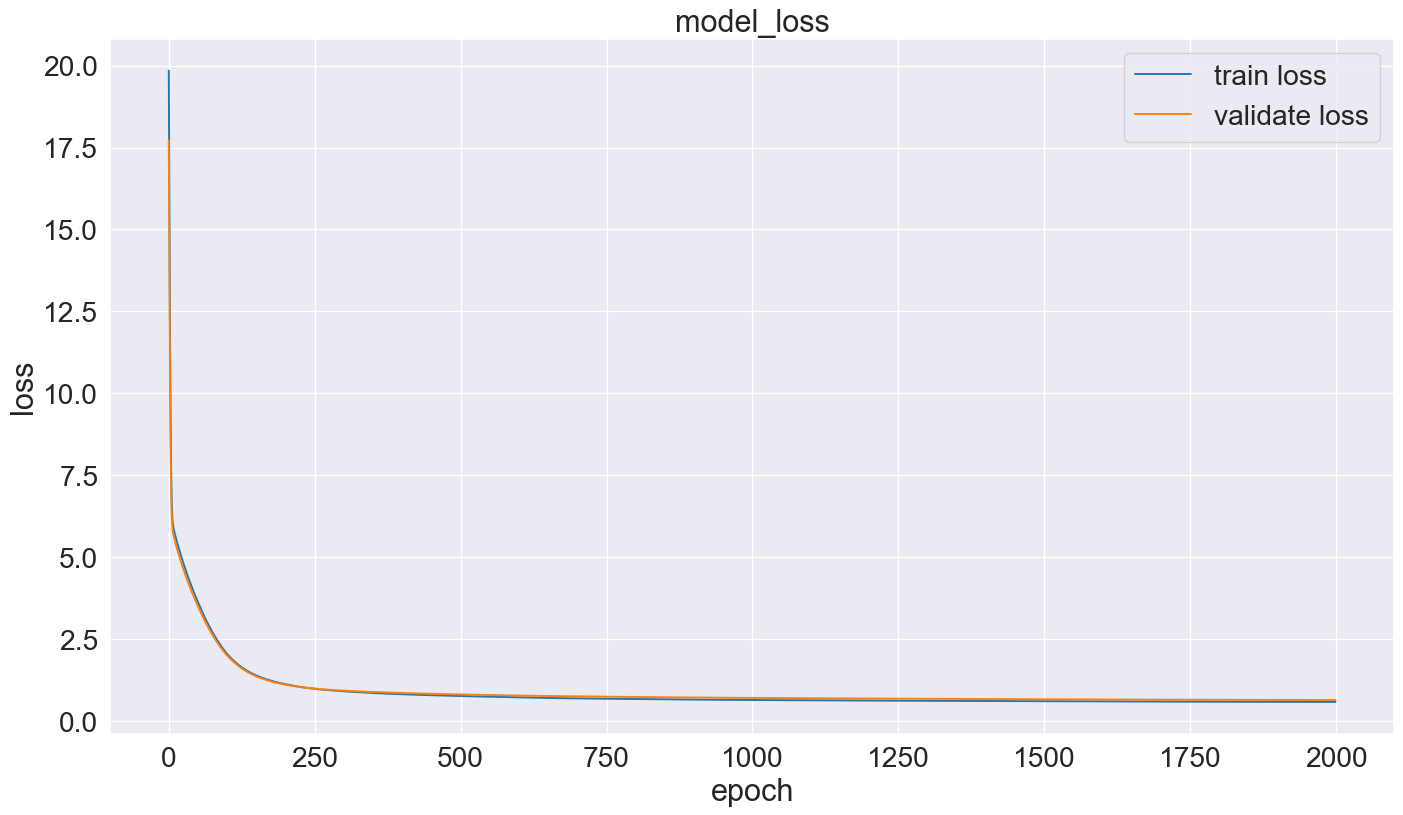

Test loss with default batch_size: 0.6434606313705444
Test loss with batch_size=4096: 0.6434605717658997
Predicted: [5.6737423], Expected: 6
Predicted: [5.1343827], Expected: 6
Predicted: [6.1297364], Expected: 6
Predicted: [5.761552], Expected: 6
Predicted: [5.6245728], Expected: 5
Predicted: [5.482627], Expected: 5
Predicted: [6.778379], Expected: 8
Predicted: [5.6323447], Expected: 5
Predicted: [5.4602075], Expected: 8
Predicted: [5.090222], Expected: 4
Predicted: [5.4536448], Expected: 5
Predicted: [6.1335826], Expected: 5
Wall time: 4min 57s


In [18]:
%%time
model = build_model(attr_count)
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Palika pat sliktāk, tagad loss ir 0.644. Krietni palielināšu apmācības koeficientu līdz 0.5

In [19]:
def build_model(input_count: int):
    kinit = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5)
    kreg = tf.keras.regularizers.l2(0.001)
    breg = tf.keras.regularizers.l2(0.001)
    areg = tf.keras.regularizers.l2(0.001)
    binit = tf.keras.initializers.Zeros()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count, kernel_initializer=kinit, kernel_regularizer=kreg, bias_initializer=binit, bias_regularizer=breg, activity_regularizer=areg, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.5)

    model.compile(loss='mse', optimizer=optimizer)

    return model

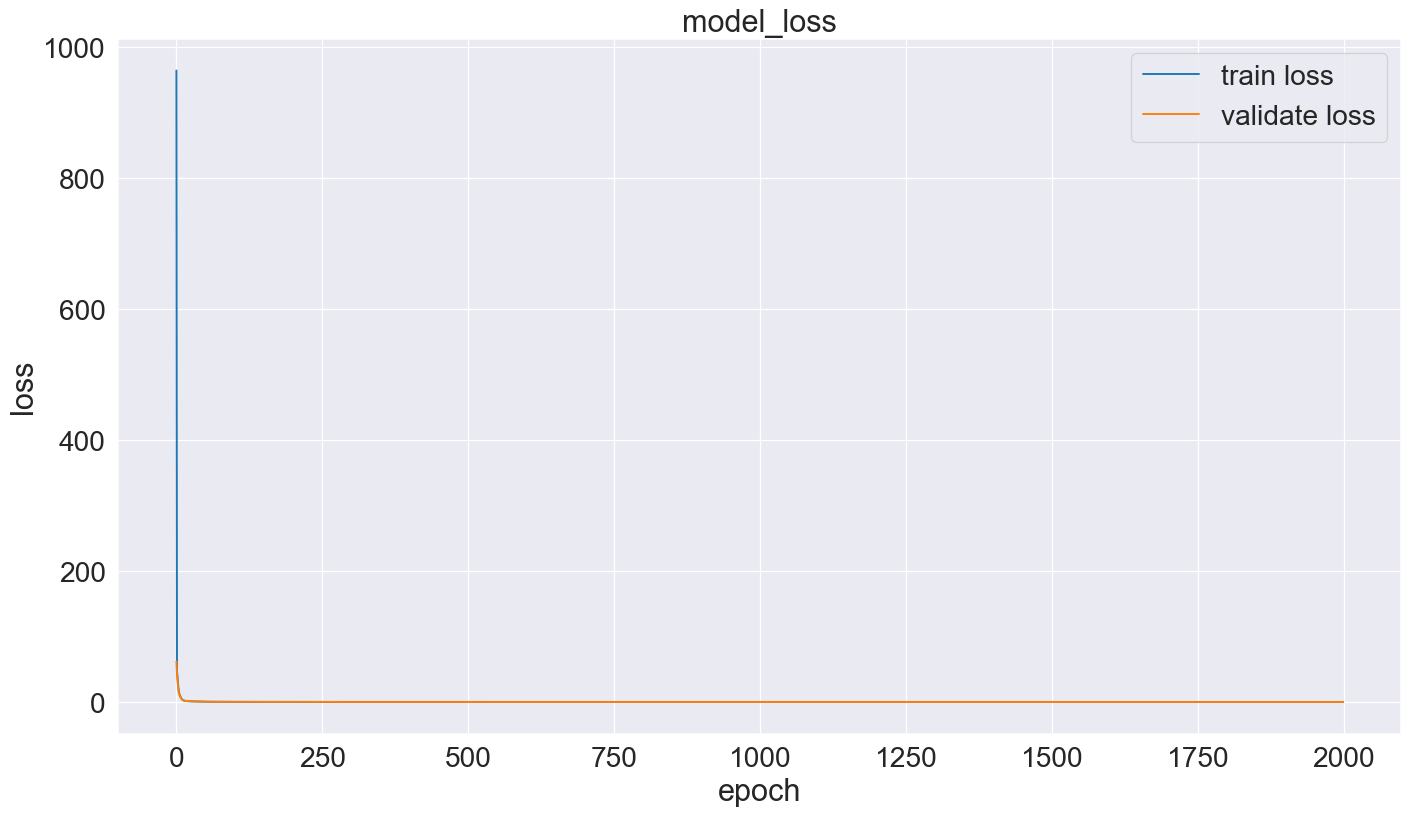

Test loss with default batch_size: 0.5972124934196472
Test loss with batch_size=4096: 0.5972124934196472
Predicted: [5.5108247], Expected: 6
Predicted: [4.9823236], Expected: 4
Predicted: [6.168393], Expected: 7
Predicted: [6.9952645], Expected: 8
Predicted: [5.7518334], Expected: 5
Predicted: [5.752161], Expected: 6
Predicted: [6.8949666], Expected: 8
Predicted: [6.2489767], Expected: 6
Predicted: [5.275073], Expected: 6
Predicted: [5.4125147], Expected: 4
Predicted: [6.6483274], Expected: 7
Predicted: [6.221643], Expected: 5
Wall time: 4min 53s


In [20]:
%%time
model = build_model(attr_count)
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Loss "uzlabojas" līdz 0.597. Pievienošu vēl vienu slāni.

In [21]:
def build_model(input_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5), 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001), 
                              bias_initializer=tf.keras.initializers.Zeros(), 
                              bias_regularizer=tf.keras.regularizers.l2(0.001), 
                              activity_regularizer=tf.keras.regularizers.l2(0.001), 
                              activation='relu'),
        tf.keras.layers.Dense(input_count, 
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5), 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001), 
                              bias_initializer=tf.keras.initializers.Zeros(), 
                              bias_regularizer=tf.keras.regularizers.l2(0.001), 
                              activity_regularizer=tf.keras.regularizers.l2(0.001), 
                              activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.5)

    model.compile(loss='mse', optimizer=optimizer)

    return model

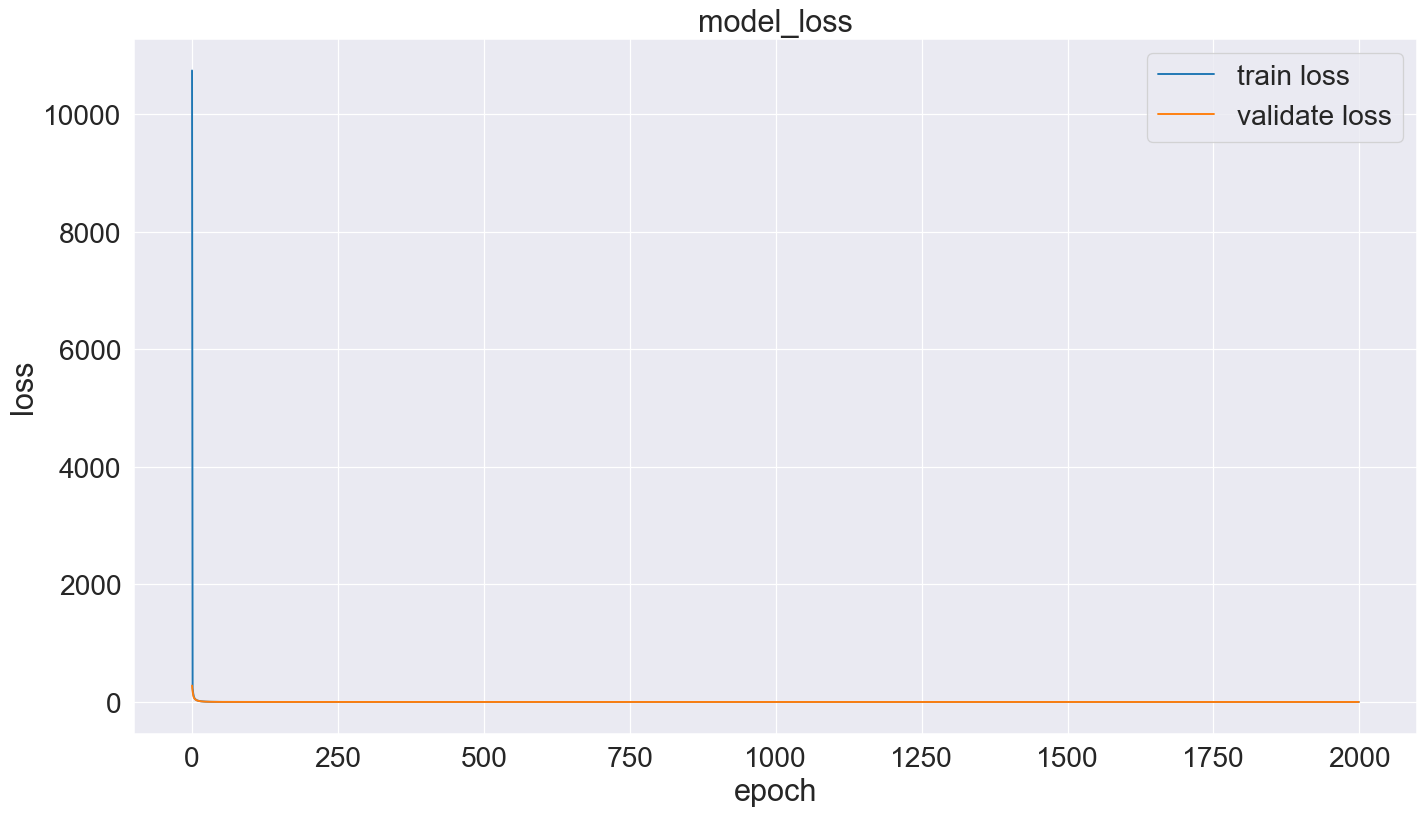

Test loss with default batch_size: 0.5463229417800903
Test loss with batch_size=4096: 0.5463228821754456
Predicted: [6.6998615], Expected: 7
Predicted: [5.4787097], Expected: 5
Predicted: [5.8479652], Expected: 6
Predicted: [5.4414396], Expected: 6
Predicted: [5.3227177], Expected: 5
Predicted: [6.00154], Expected: 6
Predicted: [5.5595303], Expected: 4
Predicted: [6.5082026], Expected: 7
Predicted: [5.873952], Expected: 4
Predicted: [6.4181595], Expected: 7
Predicted: [6.551178], Expected: 7
Predicted: [5.775155], Expected: 5
Wall time: 5min 49s


In [22]:
%%time
model = build_model(attr_count)
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Uzlabojas, bet joprojam +/- tāda pati kļūda. Un apmacīšana aizņema uz 1 minūti ilgāk. Varbūt tomēr vajag datus normalizēt.

In [23]:
n_samples = data.copy()
n_qualities = n_samples.pop('quality')
n_samples = (n_samples - n_samples.mean()) / n_samples.std()

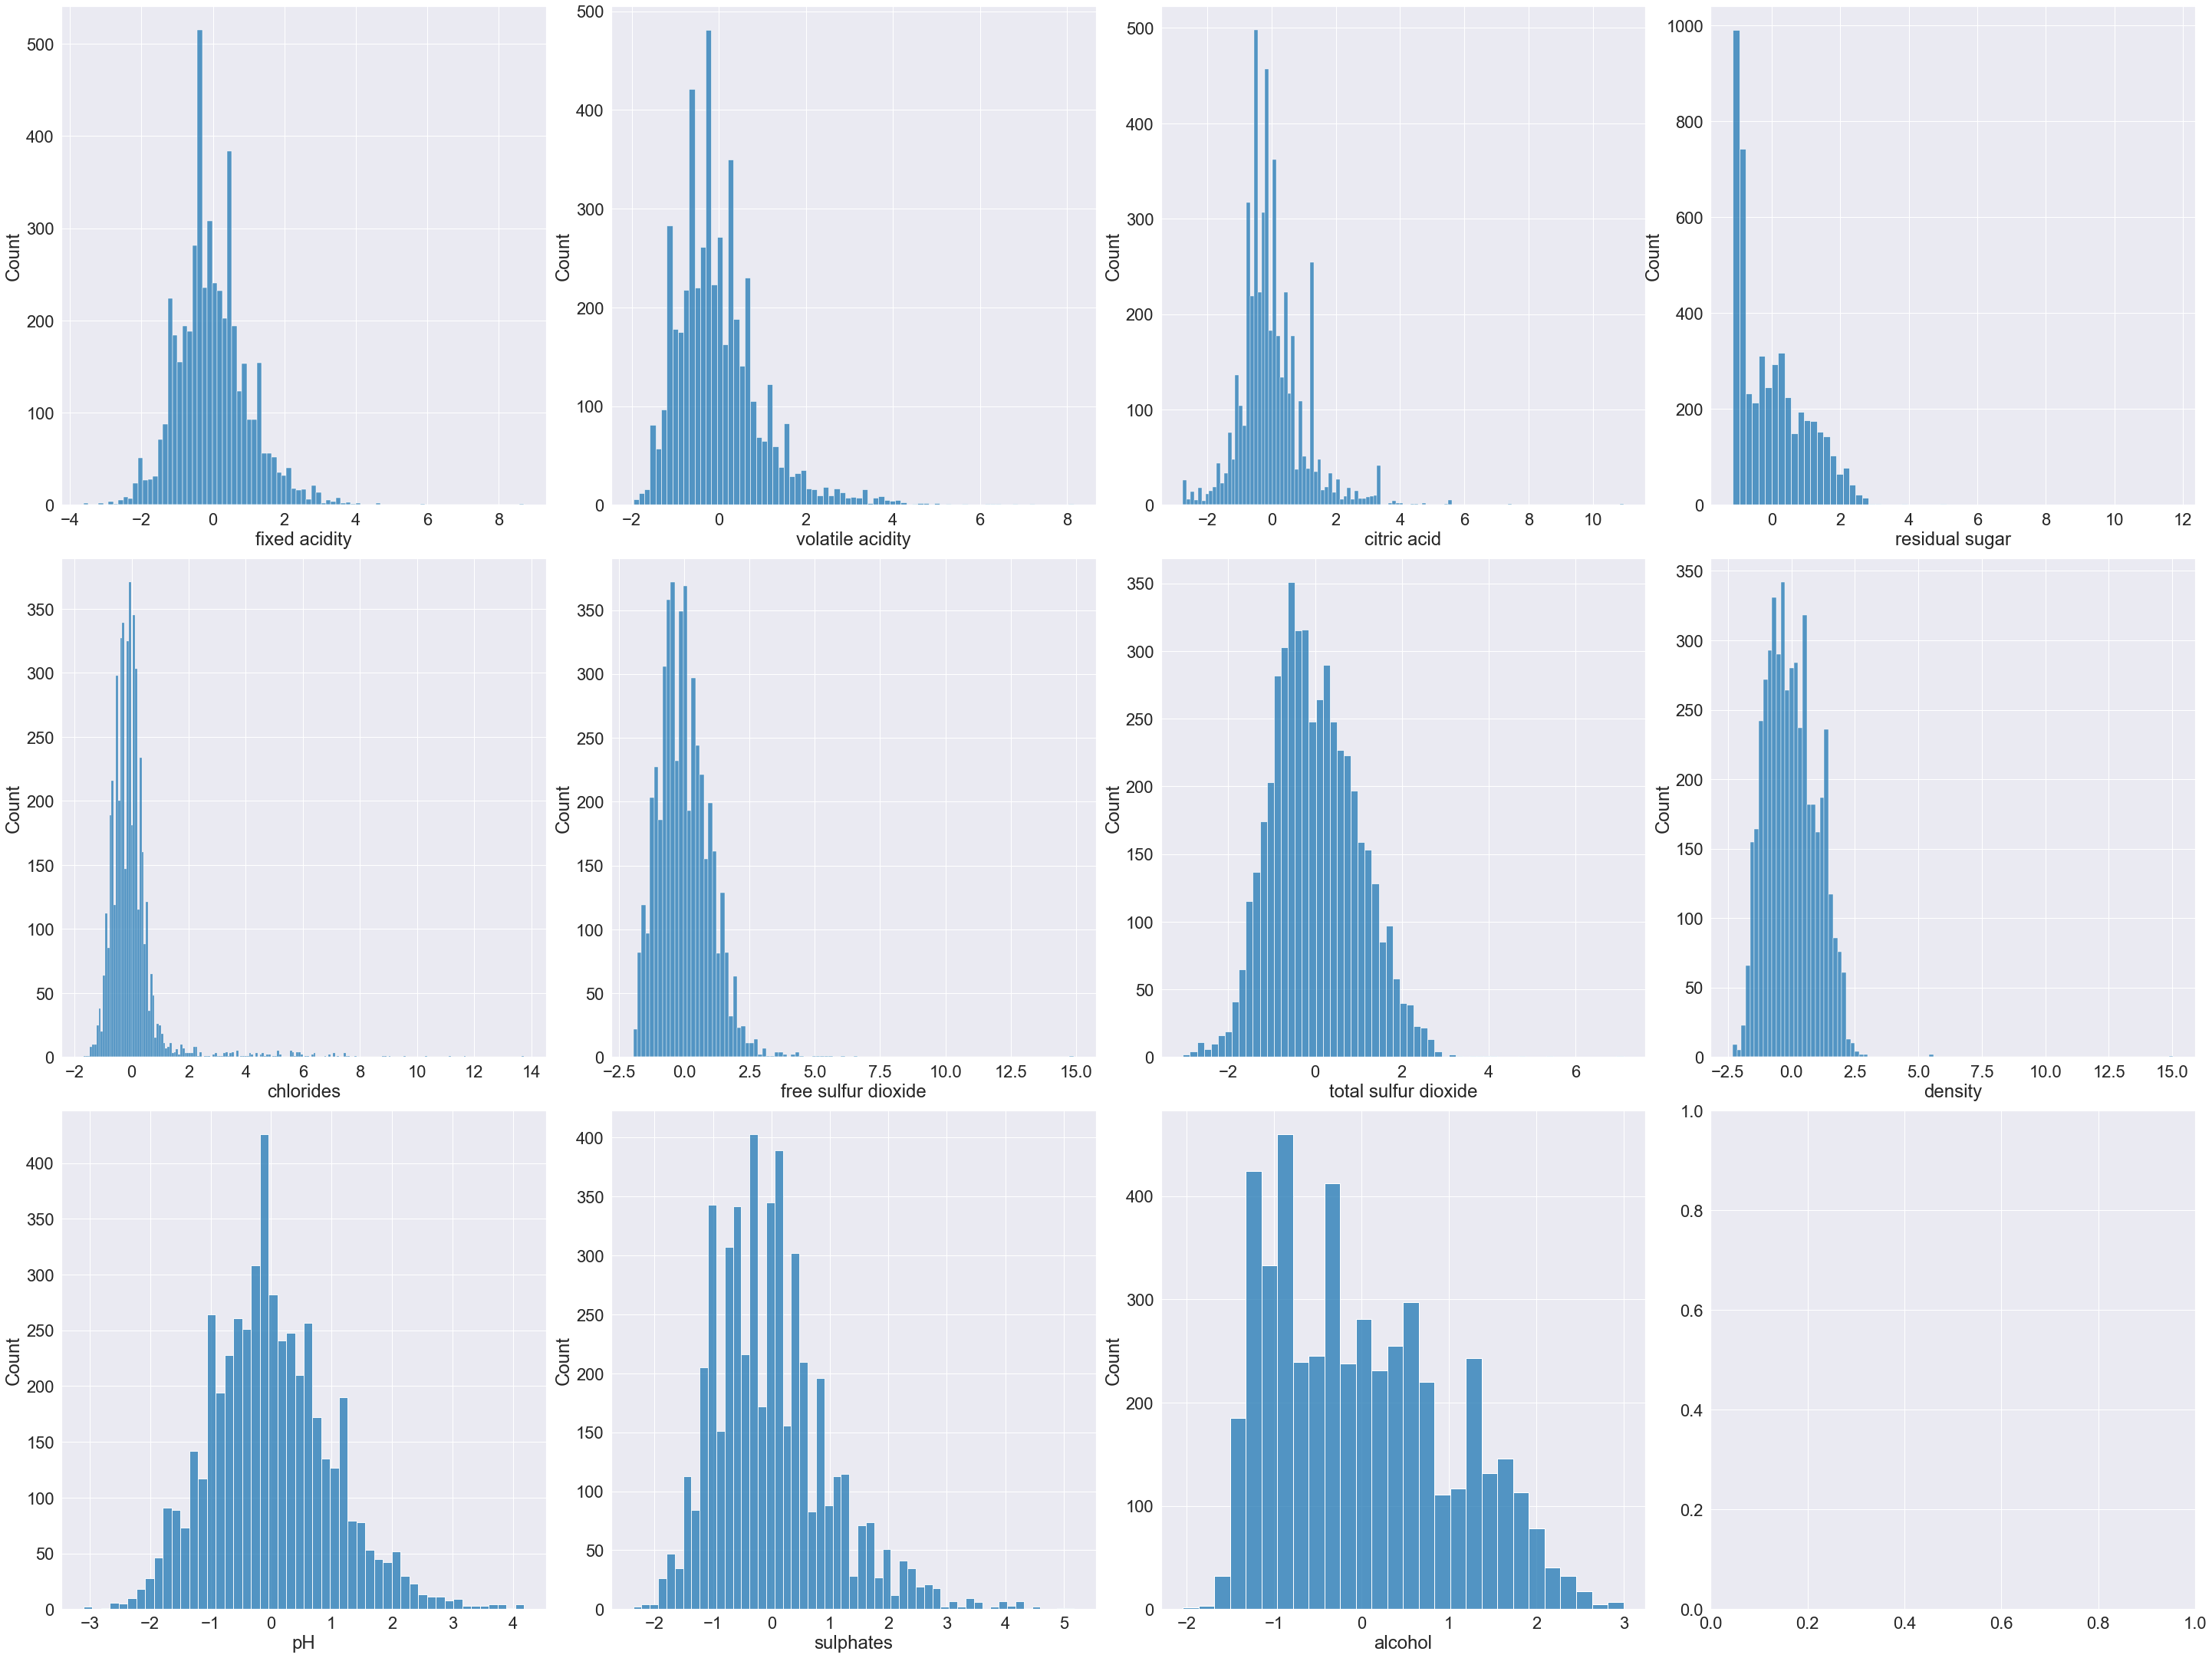

In [24]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(40, 30))
index = 0
ax = ax.flatten()

for col, value in n_samples.items():
    sns.histplot(value, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

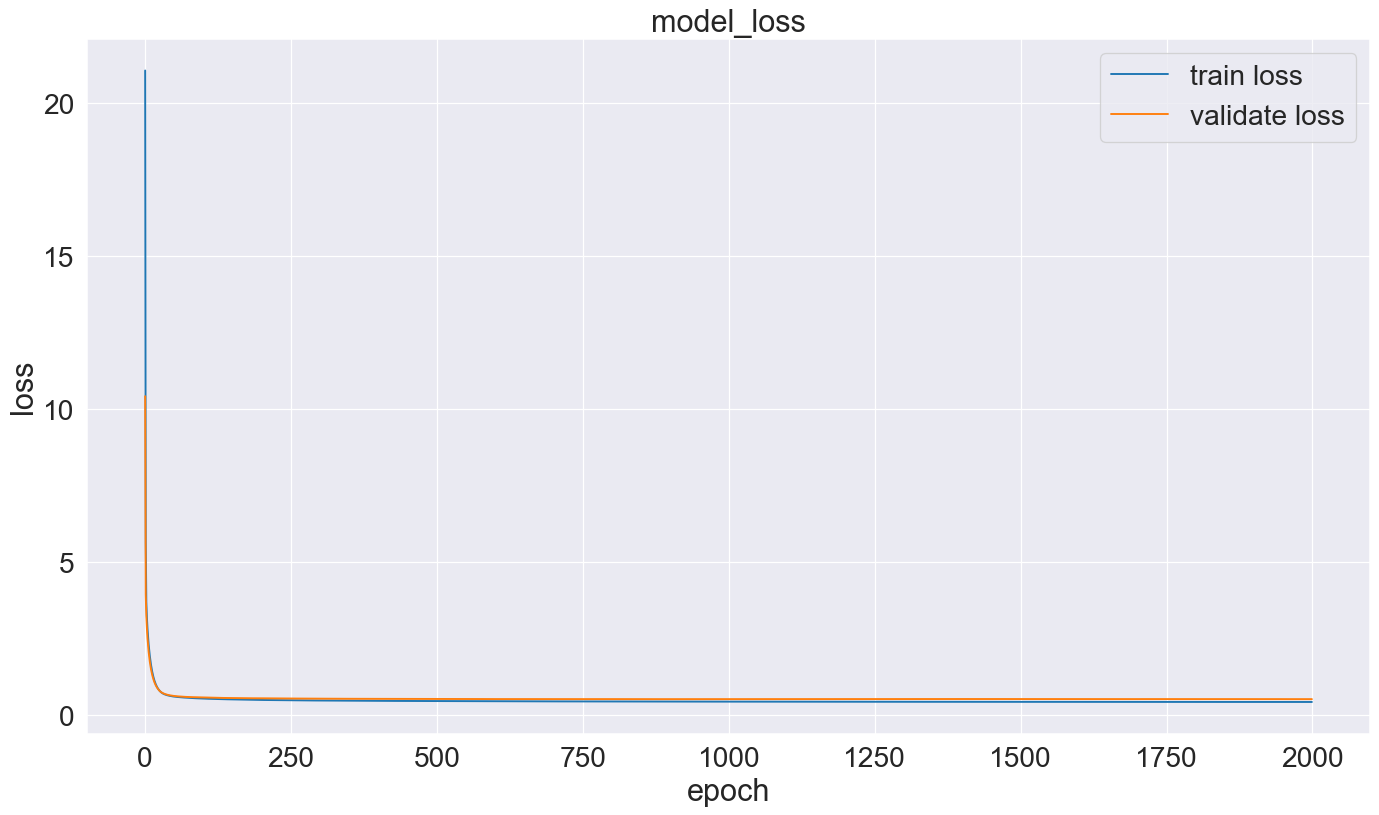

Test loss with default batch_size: 0.5311194658279419
Test loss with batch_size=4096: 0.5311194658279419
Predicted: [5.927989], Expected: 6
Predicted: [5.844634], Expected: 5
Predicted: [5.8831697], Expected: 6
Predicted: [6.7759376], Expected: 7
Predicted: [5.146757], Expected: 6
Predicted: [6.327124], Expected: 6
Predicted: [6.4099994], Expected: 6
Predicted: [5.270692], Expected: 5
Predicted: [5.7755713], Expected: 5
Predicted: [6.6232905], Expected: 6
Predicted: [6.285785], Expected: 6
Predicted: [6.409557], Expected: 6
Wall time: 5min 49s


In [25]:
%%time
model = build_model(attr_count)
evaluate_model(model, n_samples, n_qualities, plot_history, batch_size=32, epochs=EPOCHS)

Atkal ap 0.53. Vai nu neprotu ar šo pieeju uzbūvēt MNT, vai nu dati nav tik labi.

## Klasifikācijas metode

In [36]:
def plot_history(history):
    plt.figure(figsize=(18, 10), dpi=92)
    plt.plot(history.history['loss'])
    plt.plot(history.history[f'val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validate loss'], loc='best')
    plt.show()
    
    plt.figure(figsize=(18, 10), dpi=92)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history[f'val_accuracy'])
    plt.title('model_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train accuracy', 'validate accuracy'], loc='best')
    plt.show()
    
    print(f'Training accuracy: {history.history["accuracy"][-1]}')
    print(f'Training loss: {history.history["loss"][-1]}')

In [37]:
classes = {
    3: np.asarray([1, 0, 0, 0, 0, 0, 0], dtype=np.int64),
    4: np.asarray([0, 1, 0, 0, 0, 0, 0], dtype=np.int64),
    5: np.asarray([0, 0, 1, 0, 0, 0, 0], dtype=np.int64),
    6: np.asarray([0, 0, 0, 1, 0, 0, 0], dtype=np.int64),
    7: np.asarray([0, 0, 0, 0, 1, 0, 0], dtype=np.int64),
    8: np.asarray([0, 0, 0, 0, 0, 1, 0], dtype=np.int64),
    9: np.asarray([0, 0, 0, 0, 0, 0, 1], dtype=np.int64),
}

qualities = data['quality'].copy()
qualities = qualities.map(classes)

Sākšu atkal no ieejam savienotām ar izejam bez slēptiem slāņiem. Kā loss funkciju izmantošu "categorical_crossentropy" nevis "binary_crossentropy", jo man ir vairākas kategorijas (kvalitātes). Binary izmanto, kad ir jāatbild "jā" vai "nē" un tikai vienreiz.

In [38]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.003)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

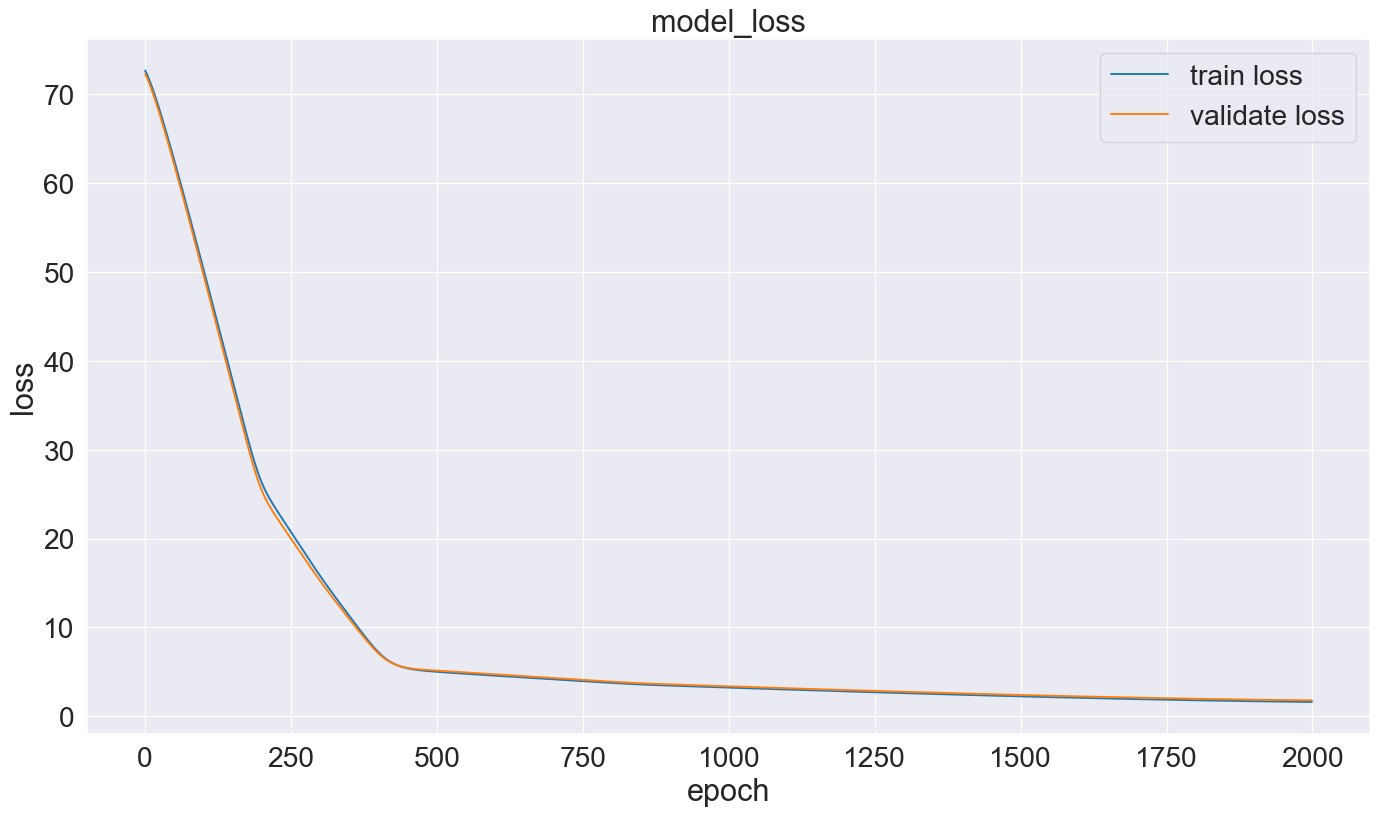

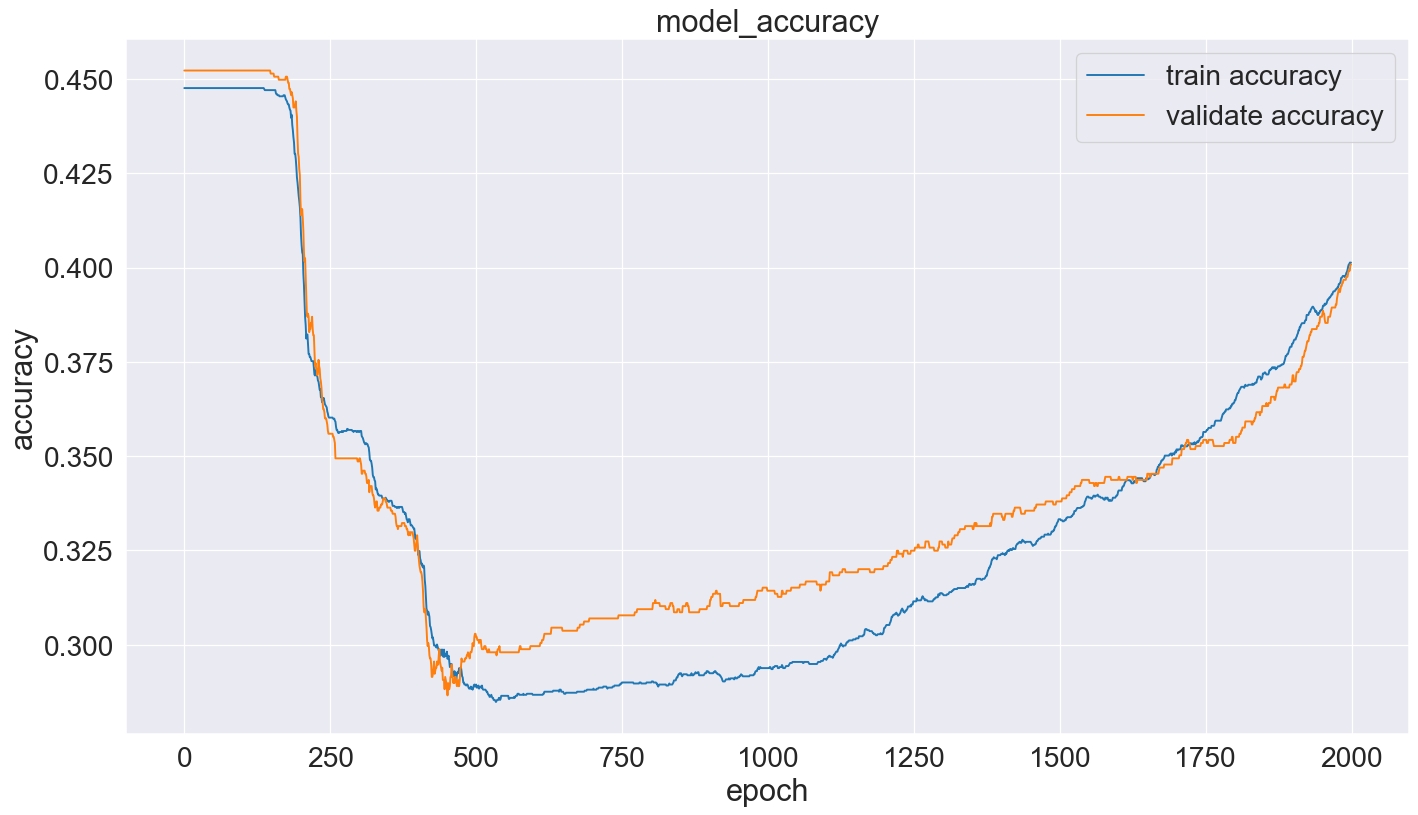

Training accuracy: 0.4013068377971649
Training loss: 1.6143954992294312
Test loss with default batch_size: [1.789621353149414, 0.40081632137298584]
Test loss with batch_size=4096: [1.789621353149414, 0.40081632137298584]
Predicted: [7.4766678e-05 1.0541504e-05 4.3218353e-01 3.6903286e-01 1.8403849e-01
 1.4659813e-02 3.6032714e-29], Expected: [0 0 0 0 0 1 0]
Predicted: [7.9974666e-04 1.7184115e-04 1.9531159e-01 5.0838608e-01 2.9507598e-01
 2.5479833e-04 7.9478277e-37], Expected: [0 0 1 0 0 0 0]
Predicted: [9.2304882e-04 2.4649424e-03 2.7586520e-01 4.3136755e-01 2.8573605e-01
 3.6431260e-03 1.1255062e-20], Expected: [0 0 1 0 0 0 0]
Predicted: [9.0504196e-05 4.0216933e-06 2.2519664e-01 5.1805133e-01 2.4298415e-01
 1.3673405e-02 3.7301029e-31], Expected: [0 0 0 1 0 0 0]
Predicted: [2.2229829e-03 4.5563473e-05 1.7370443e-01 6.5841824e-01 1.6559856e-01
 1.0155092e-05 0.0000000e+00], Expected: [0 0 0 0 1 0 0]
Predicted: [2.1259941e-05 2.2479941e-08 5.7463026e-01 2.4611050e-01 8.7753735e-02
 9

In [39]:
%%time
model = build_model(attr_count, len(classes))
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Izskatas, ka precizitāte varēja pieaugt vēl. Atkal pievienošu vienu slāni, bet tagad ar Sigmoid aktivācijas funkciju.

In [40]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.03)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

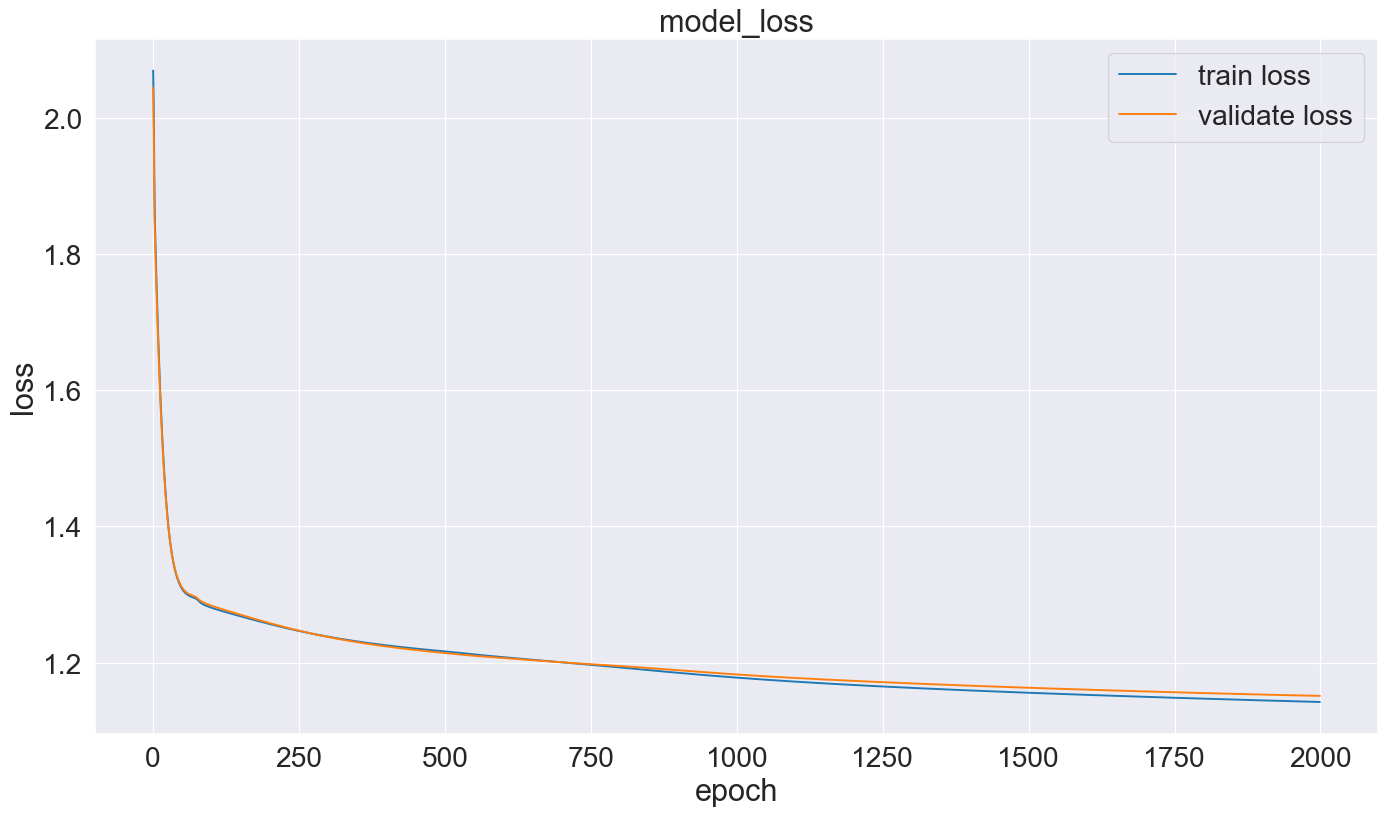

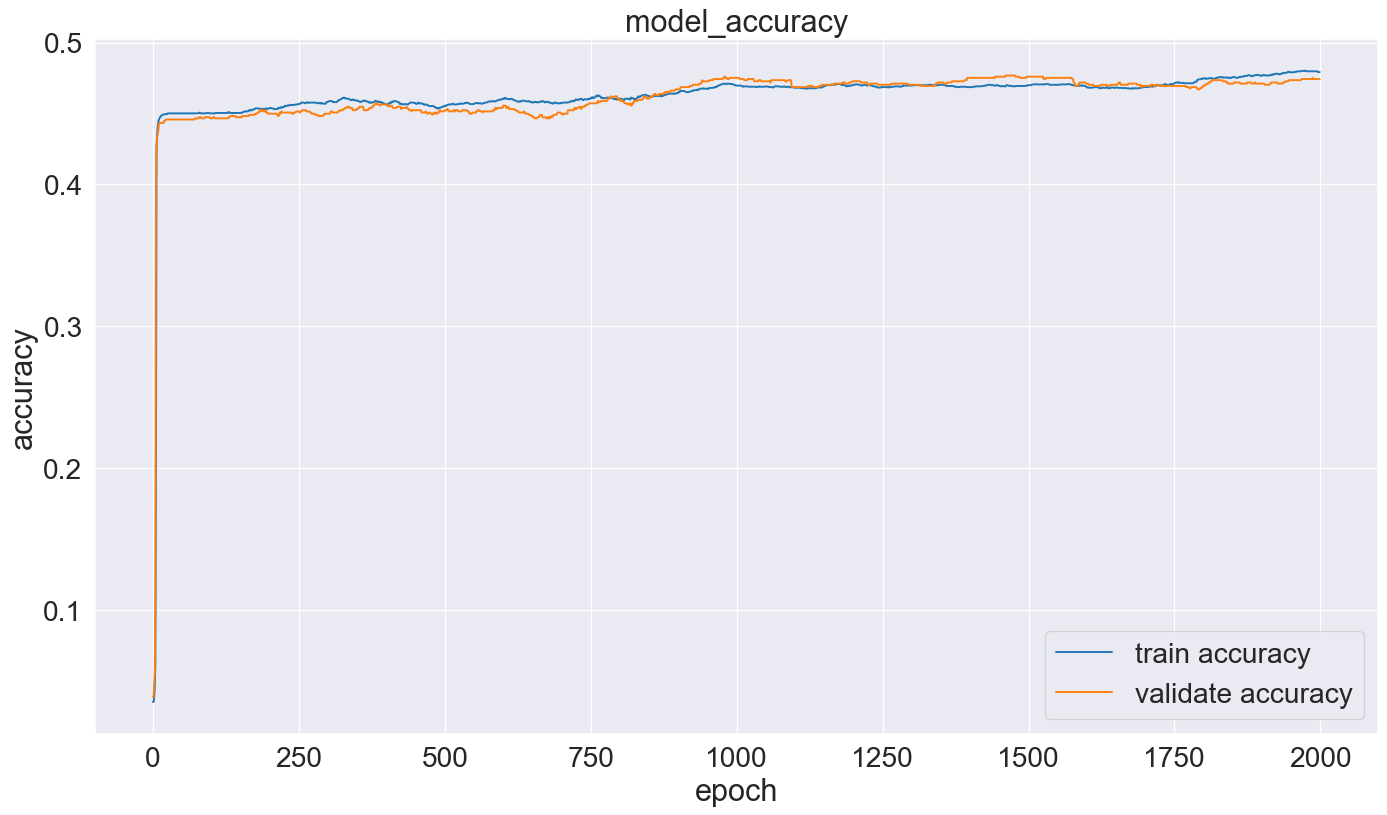

Training accuracy: 0.47917234897613525
Training loss: 1.1422810554504395
Test loss with default batch_size: [1.1512138843536377, 0.47428572177886963]
Test loss with batch_size=4096: [1.1512140035629272, 0.47428572177886963]
Predicted: [0.00332396 0.03907331 0.5293939  0.37091127 0.04720354 0.00894564
 0.00114831], Expected: [0 0 0 1 0 0 0]
Predicted: [0.00230517 0.01166841 0.08238465 0.45110005 0.38190305 0.07000636
 0.00063233], Expected: [0 0 0 0 1 0 0]
Predicted: [0.00326434 0.01864307 0.43193522 0.45077702 0.08019968 0.01469547
 0.00048523], Expected: [0 0 0 0 1 0 0]
Predicted: [0.00988476 0.16593723 0.4397792  0.29408142 0.06492247 0.02332489
 0.00207   ], Expected: [0 0 1 0 0 0 0]
Predicted: [0.00303853 0.0269369  0.22227316 0.52146953 0.19146328 0.03345671
 0.00136185], Expected: [0 0 1 0 0 0 0]
Predicted: [0.00591253 0.04212485 0.11313404 0.39556202 0.34159088 0.10065036
 0.0010253 ], Expected: [0 0 0 1 0 0 0]
Predicted: [0.00326449 0.01901101 0.4419634  0.44460544 0.07659756 0

In [41]:
%%time
model = build_model(attr_count, len(classes))
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Pievienošu vēl divus slāņus.

In [48]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.03)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

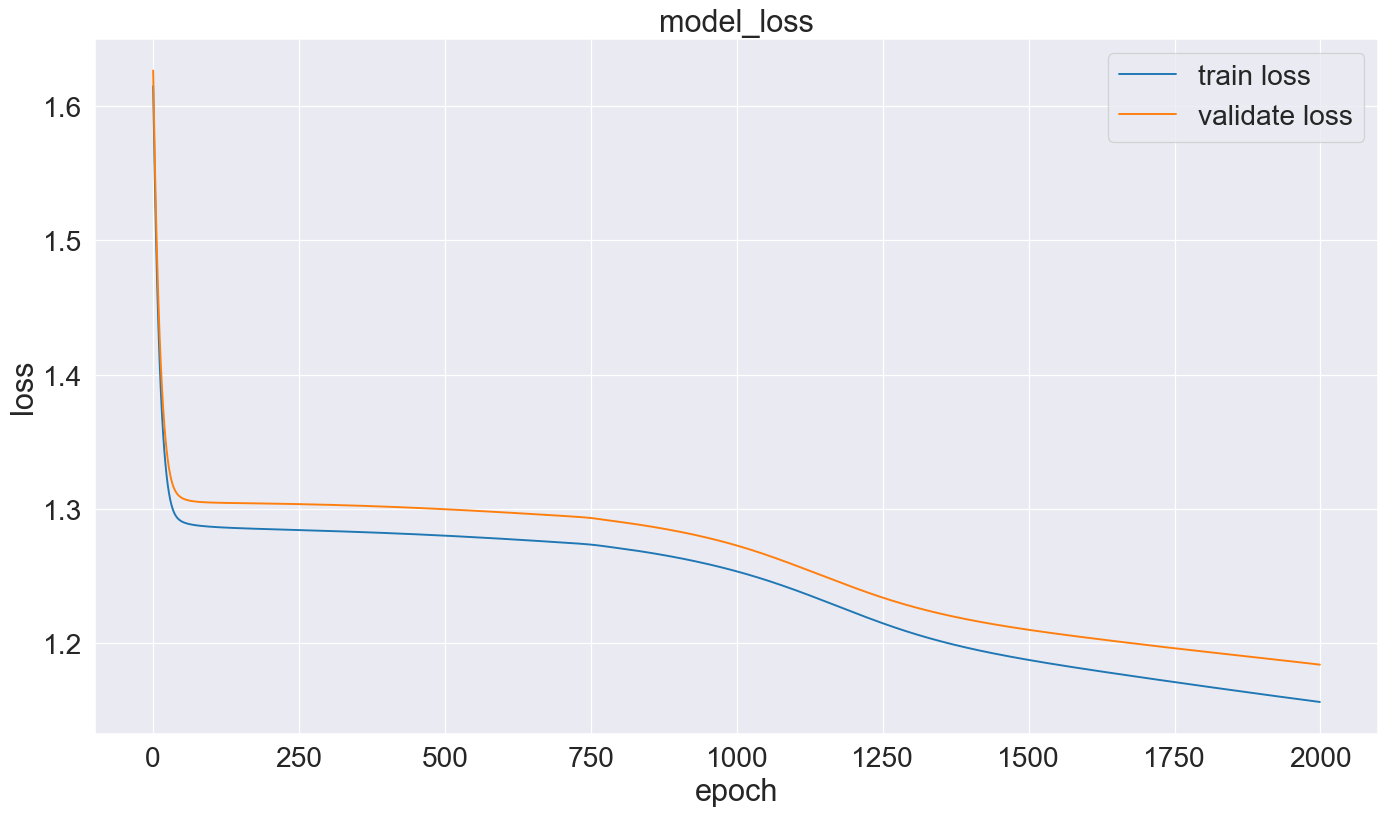

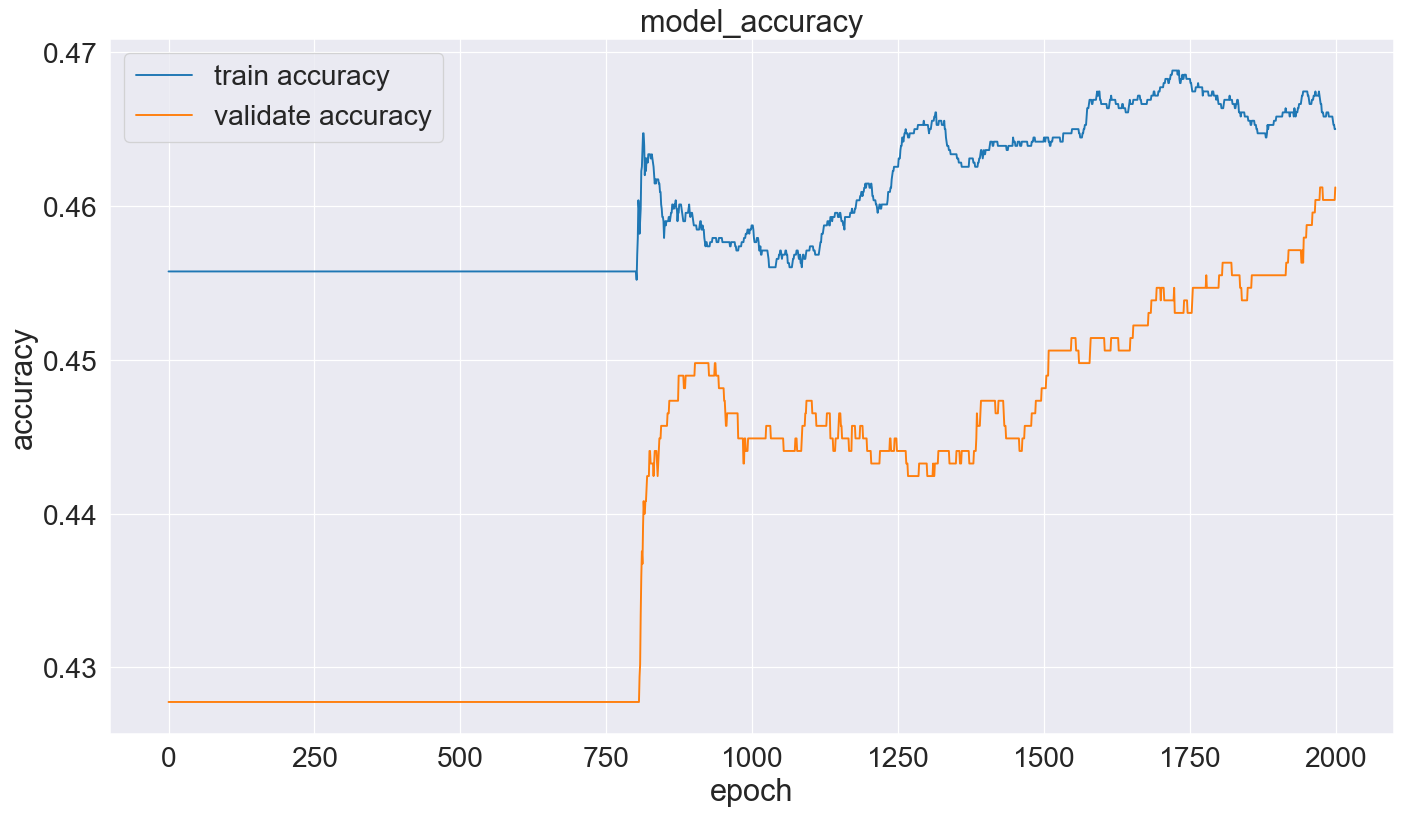

Training accuracy: 0.4650149643421173
Training loss: 1.1563886404037476
Test loss with default batch_size: [1.184187412261963, 0.4612244963645935]
Test loss with batch_size=4096: [1.1841870546340942, 0.4612244963645935]
Predicted: [2.4077517e-03 2.6352016e-02 4.0814319e-01 4.6520838e-01 7.7955261e-02
 1.9547662e-02 3.8567404e-04], Expected: [0 0 1 0 0 0 0]
Predicted: [2.7382702e-03 2.9095564e-02 3.9131382e-01 4.6805647e-01 8.6896390e-02
 2.1446273e-02 4.5321370e-04], Expected: [0 0 0 1 0 0 0]
Predicted: [2.4138563e-03 2.7125381e-02 4.1442168e-01 4.6086681e-01 7.5714886e-02
 1.9072844e-02 3.8457371e-04], Expected: [0 0 0 1 0 0 0]
Predicted: [0.0030288  0.00912588 0.12023354 0.4855967  0.32025298 0.06102707
 0.00073505], Expected: [0 0 0 1 0 0 0]
Predicted: [2.5036377e-03 2.7280772e-02 4.0415388e-01 4.6546373e-01 8.0172077e-02
 2.0021264e-02 4.0457447e-04], Expected: [0 0 1 0 0 0 0]
Predicted: [2.4162256e-03 2.6599402e-02 4.0931225e-01 4.6422356e-01 7.7590697e-02
 1.9471083e-02 3.8679558

In [50]:
%%time
model = build_model(attr_count, len(classes))
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Palielināšu learning rate līdz 0.75

In [51]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.75)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

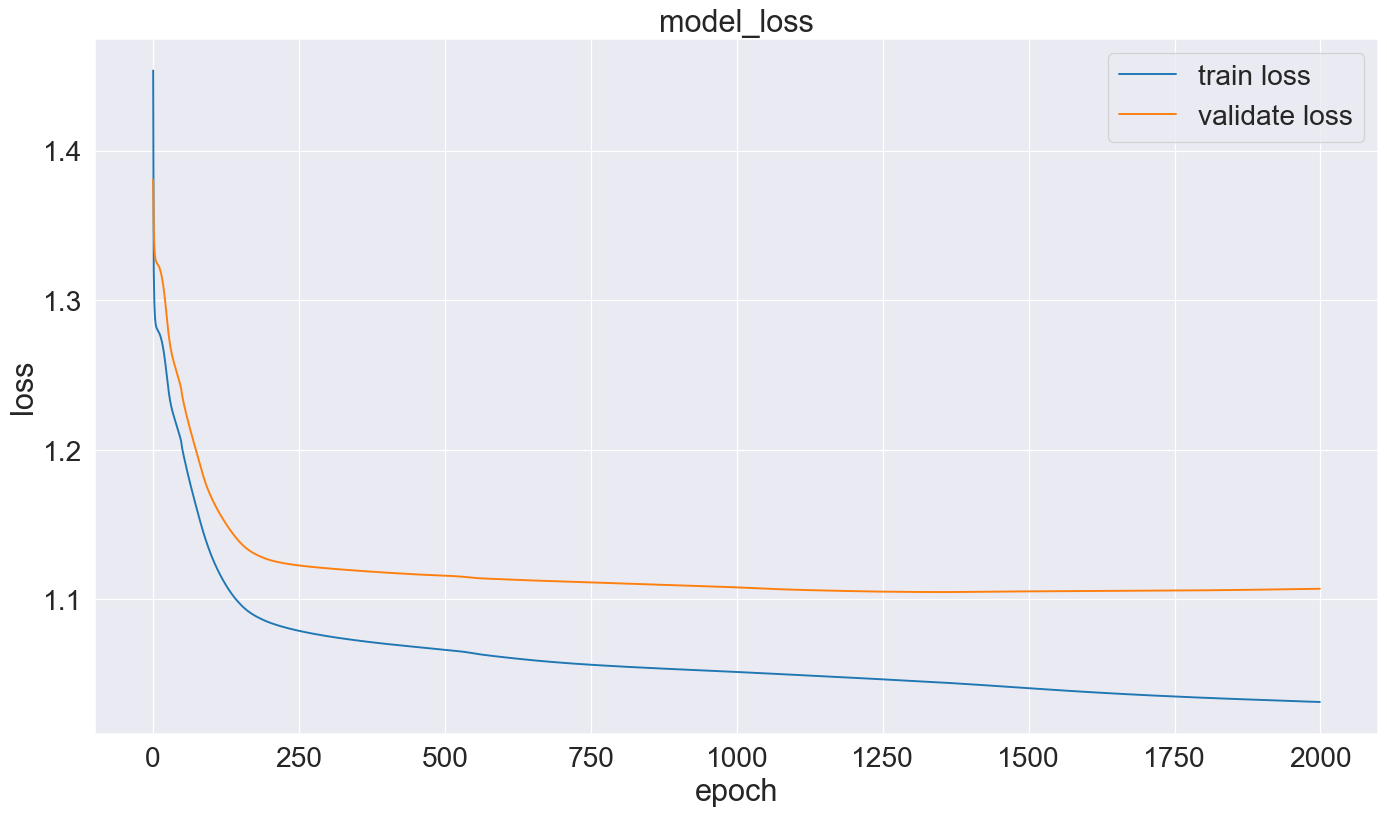

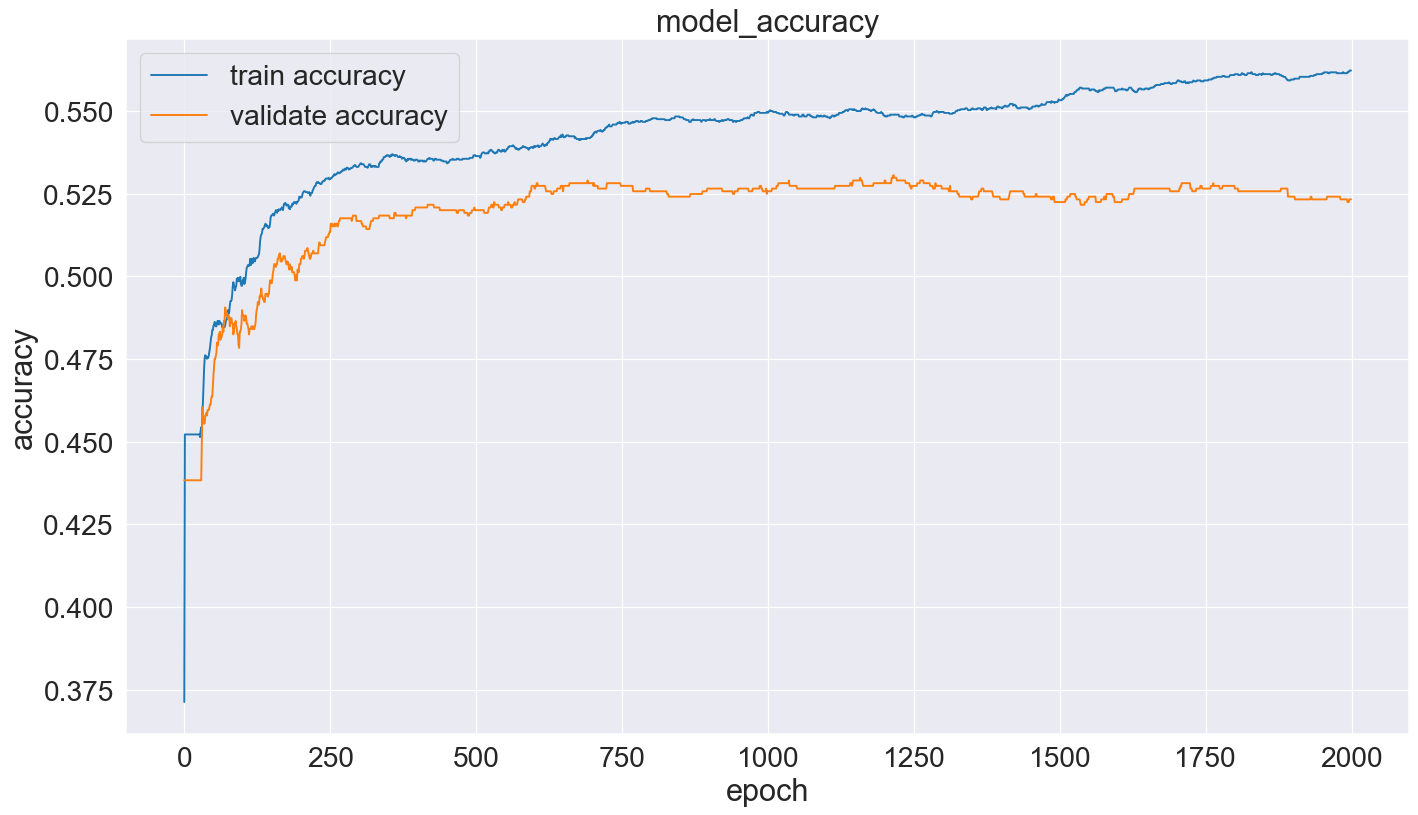

Training accuracy: 0.562210738658905
Training loss: 1.0312172174453735
Test loss with default batch_size: [1.1069207191467285, 0.5232653021812439]
Test loss with batch_size=4096: [1.106920838356018, 0.5232653021812439]
Predicted: [1.4142813e-02 1.7940944e-01 6.1867160e-01 1.7889553e-01 7.5613069e-03
 1.3093917e-03 1.0003409e-05], Expected: [0 0 1 0 0 0 0]
Predicted: [0.00067742 0.00630087 0.12723559 0.5955978  0.24228117 0.02729607
 0.00061108], Expected: [0 0 0 1 0 0 0]
Predicted: [4.3577480e-04 3.3682866e-03 6.1148580e-02 5.6918633e-01 3.1619924e-01
 4.8804626e-02 8.5713738e-04], Expected: [0 0 0 0 1 0 0]
Predicted: [1.31959235e-02 1.79350168e-01 6.35067821e-01 1.64318442e-01
 6.94922032e-03 1.11069554e-03 7.69728376e-06], Expected: [0 0 1 0 0 0 0]
Predicted: [1.4942553e-04 2.0729166e-03 4.1066191e-01 5.0817716e-01 7.0253722e-02
 8.5626384e-03 1.2230664e-04], Expected: [0 0 0 1 0 0 0]
Predicted: [3.8887956e-04 4.7462280e-03 7.0204908e-01 2.8574547e-01 5.9966915e-03
 1.0667740e-03 6.7

In [52]:
%%time
model = build_model(attr_count, len(classes))
evaluate_model(model, samples, qualities, plot_history, batch_size=32, epochs=EPOCHS)

Palika labāk. Sabalansēšu datus, jo man liekas, ka tomēr tas ietekmē precizitāti. Jo dažām kvalitātes kategorijām ir pa maz datu.

In [53]:
n_samples = data.copy()
n_qualities = n_samples.pop('quality')

smote = SMOTE(k_neighbors=4)
smote_enn = SMOTEENN(smote=smote, random_state=0)

n_samples, n_qualities = smote_enn.fit_resample(n_samples, n_qualities)

n_qualities = n_qualities.map(classes)
n_samples = (n_samples - n_samples.mean()) / n_samples.std()

In [54]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.75)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

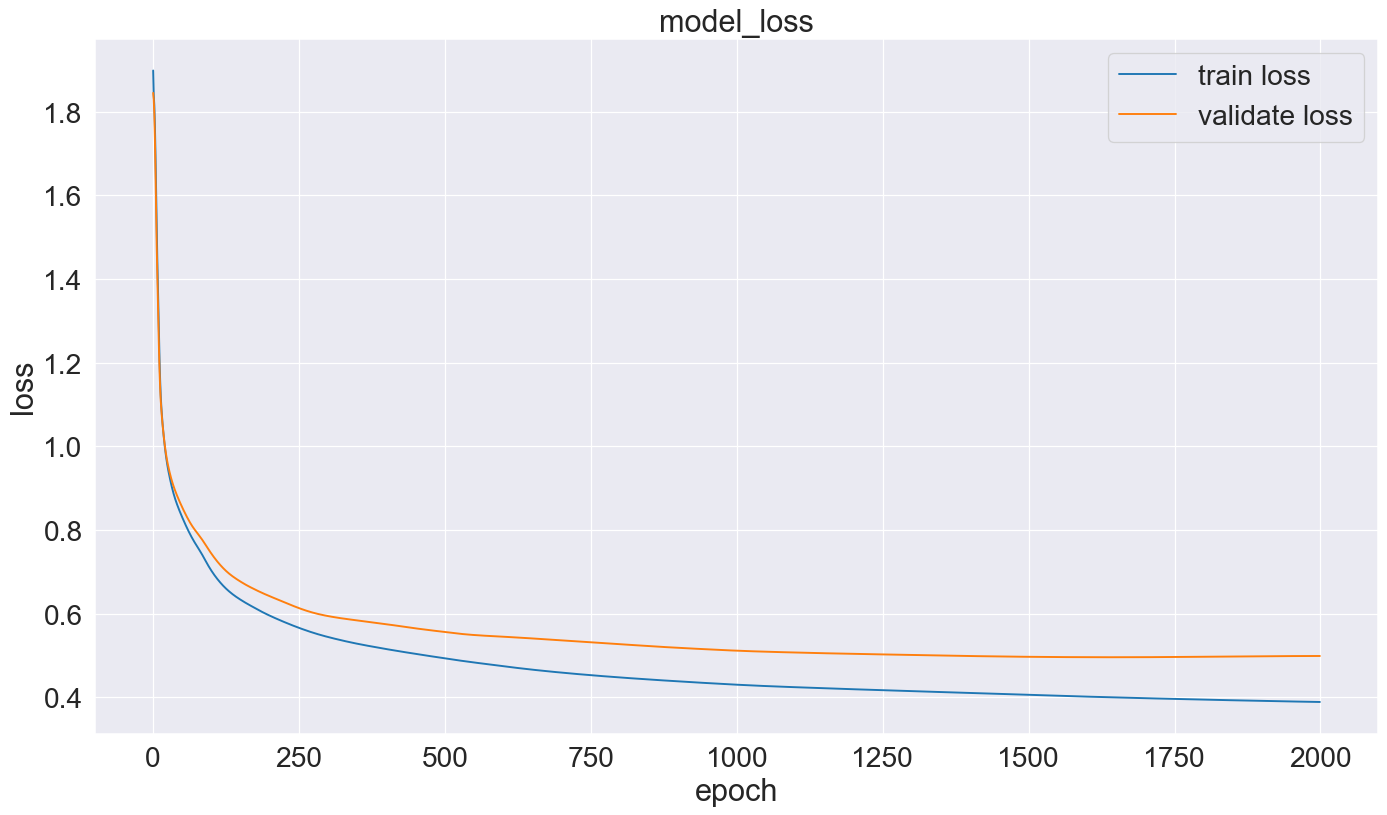

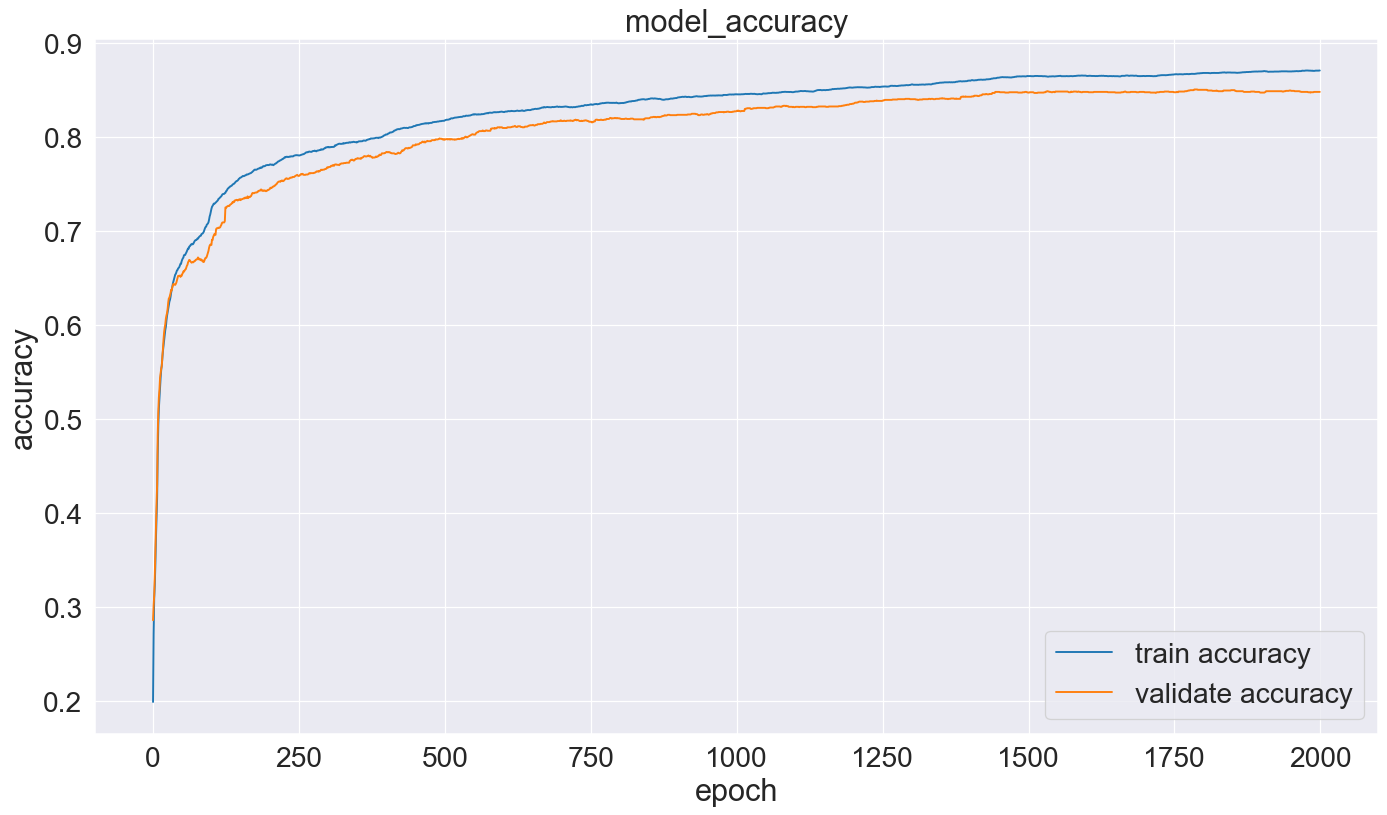

Training accuracy: 0.8703726530075073
Training loss: 0.38871705532073975
Test loss with default batch_size: [0.4986976981163025, 0.8476576805114746]
Test loss with batch_size=4096: [0.4986976087093353, 0.8476576805114746]
Predicted: [4.5446380e-14 3.9207689e-03 7.5618164e-03 3.6897399e-02 6.3705826e-01
 3.1456178e-01 2.0598115e-13], Expected: [0 0 0 0 1 0 0]
Predicted: [9.8507456e-04 4.8486769e-02 4.7602583e-02 1.9148644e-02 5.8271084e-02
 8.2550585e-01 6.1015366e-11], Expected: [0 0 0 0 0 1 0]
Predicted: [2.3609632e-12 2.4871895e-05 2.1169877e-02 1.7499721e-01 7.9616189e-01
 7.6460843e-03 5.8619647e-14], Expected: [0 0 0 0 0 1 0]
Predicted: [1.0271130e-12 1.6244075e-12 1.0283349e-11 4.4594786e-10 3.7660929e-08
 3.8776452e-08 9.9999988e-01], Expected: [0 0 0 0 0 0 1]
Predicted: [4.9253485e-01 2.5795698e-01 2.4818367e-01 1.1002900e-03 2.2022257e-04
 4.0335135e-06 1.5416813e-15], Expected: [0 0 1 0 0 0 0]
Predicted: [1.6687753e-16 1.7388308e-03 6.8809325e-01 2.3366244e-01 7.6423198e-02
 

In [56]:
%%time
model = build_model(attr_count, len(classes))
evaluate_model(model, n_samples, n_qualities, plot_history, batch_size=32, epochs=EPOCHS)

Precizitāte krietni pieauga. Un arī apmācīšanas laiks dēļ datu ierakstu pieauguma. Pamēģinu pamainīt loss funkciju uz populāro Adam

In [ ]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count,
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              kernel_regularizer=tf.keras.regularizers.l2(0.00001),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                              bias_regularizer=tf.keras.regularizers.l2(0.00001),
                              activity_regularizer=tf.keras.regularizers.l2(0.00001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

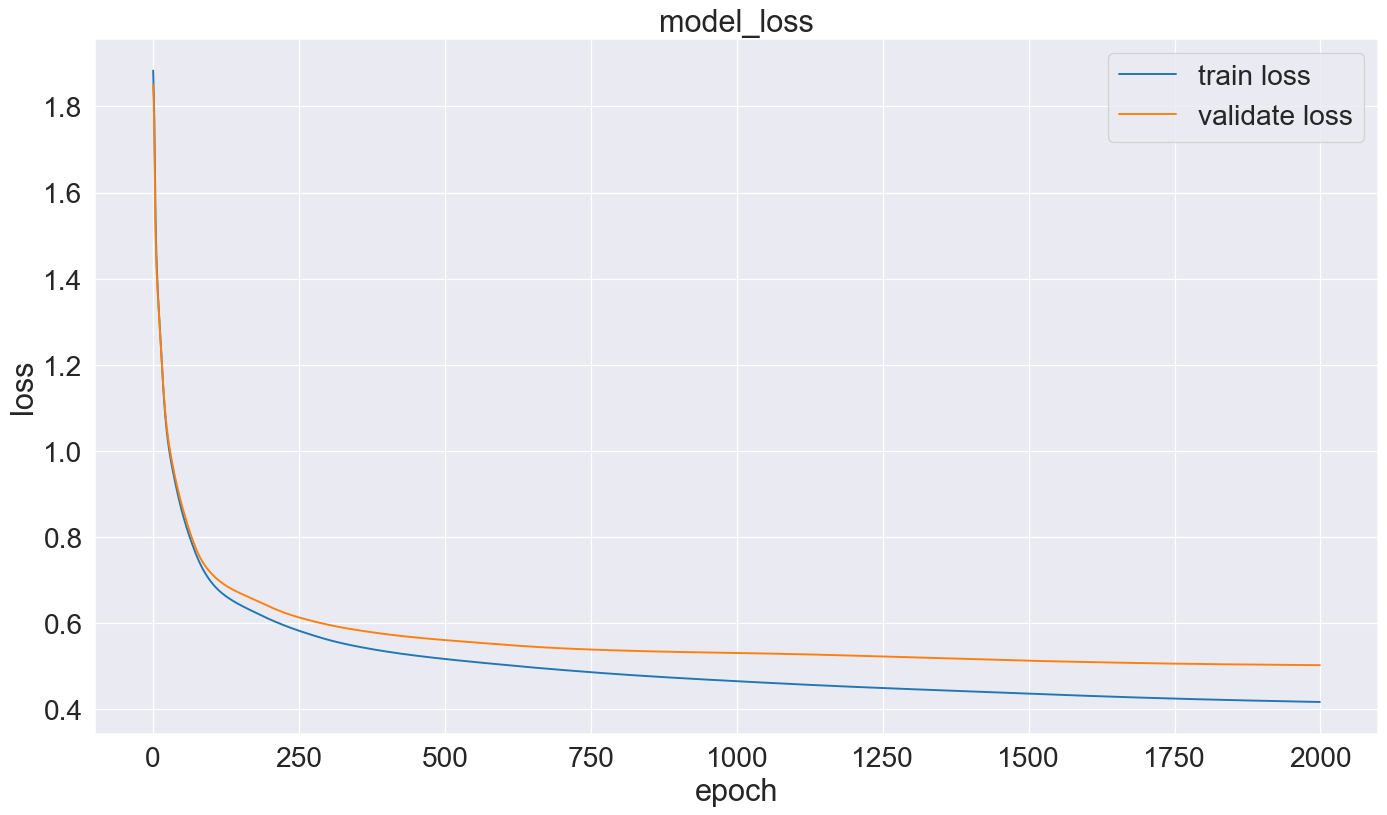

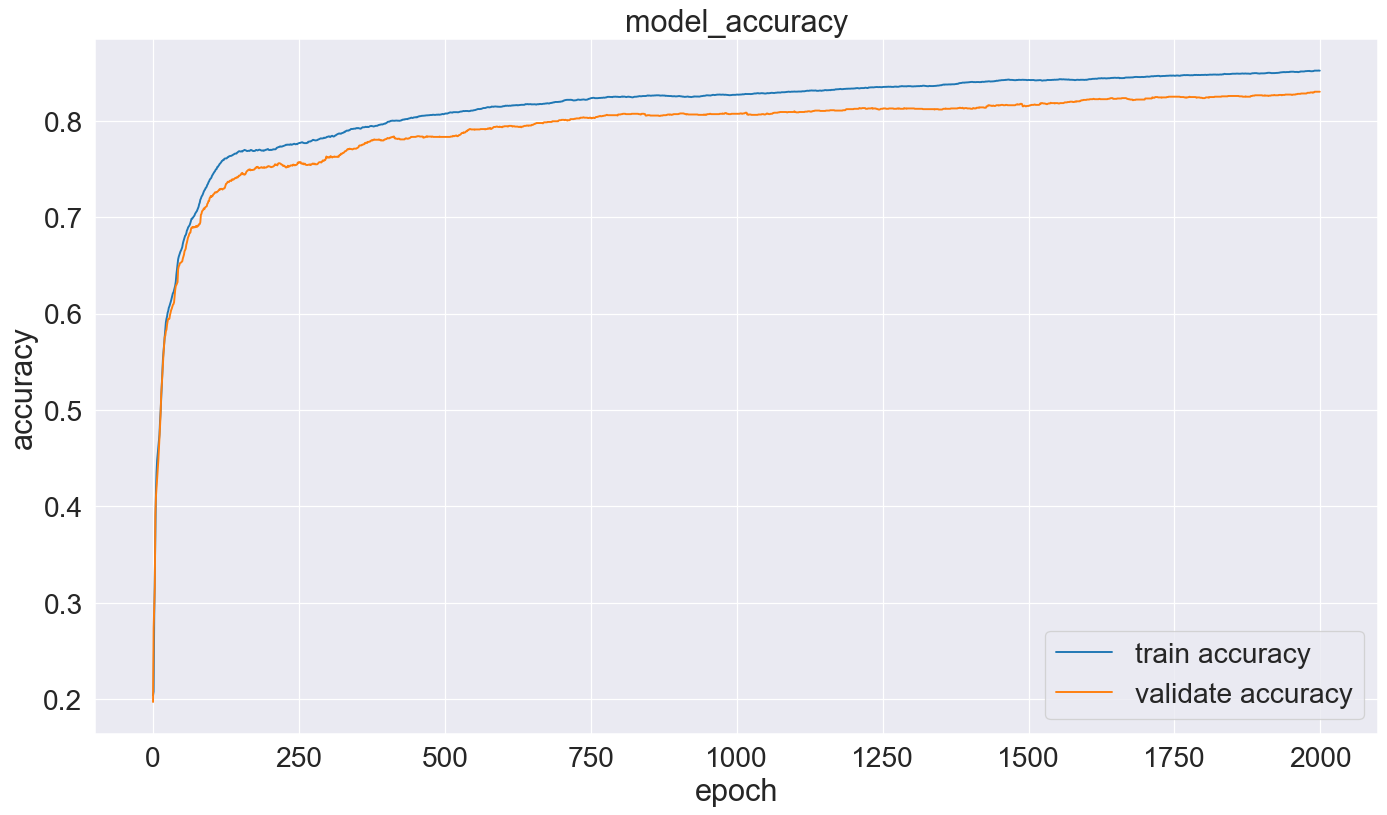

Training accuracy: 0.8518017530441284
Training loss: 0.4171901345252991
Test loss with default batch_size: [0.5026522874832153, 0.8299520611763]
Test loss with batch_size=4096: [0.5026521682739258, 0.8299520611763]
Predicted: [1.3937837e-12 3.0754310e-10 2.9292653e-04 3.2779570e-03 7.1016595e-02
 9.2541248e-01 7.1797048e-09], Expected: [0 0 0 0 0 1 0]
Predicted: [2.1777000e-11 8.0096364e-14 3.1901476e-07 5.5710225e-05 3.9166230e-04
 1.4537178e-03 9.9809855e-01], Expected: [0 0 0 0 0 0 1]
Predicted: [6.6221181e-11 4.3792209e-01 2.6044023e-01 1.3155735e-01 1.6990578e-01
 1.7456438e-04 2.6329122e-10], Expected: [0 0 0 1 0 0 0]
Predicted: [9.9740309e-01 7.6867391e-06 2.2941548e-04 5.4508830e-05 7.7743153e-04
 1.5278584e-03 3.8809933e-09], Expected: [1 0 0 0 0 0 0]
Predicted: [6.5596839e-03 9.8892015e-01 4.5030932e-03 6.6797861e-06 1.0356753e-05
 3.9442713e-11 1.6678513e-16], Expected: [0 1 0 0 0 0 0]
Predicted: [8.3638027e-11 1.4064402e-13 2.5366296e-07 3.0610479e-06 3.7916852e-04
 1.20672

In [57]:
%%time
model = build_model(attr_count, len(classes))
evaluate_model(model, n_samples, n_qualities, plot_history, batch_size=32, epochs=EPOCHS)

## Secinājumi

* Nekādi nevar zināt, vai vajag vairāk vai mazāk slēpto slāņu un to neironu skaitu. Ļoti daudz kas var būt par iemēslu zemai precizitātei - sākot no datiem un beidzot ar daudziem MNT parametriem.
* Lai varētu pārbaudīt modeļus un kaut ko secināt - vajag uzstādīt Pythonā, NumPyā, TensorFlowā utt. radnom seed kā konstāntu. Citādi viens un tas pats modelis uzvedīsies dažādi.
* Secināt kaut ko par modeli pēc 5 minūtēm nevajag. Piemēram man bija precīzitāte 0.72 pēc 30 minūtēm, bet pēc 44.5 stundām jau 0.8338. Kā arī var aiziet citā virzienā. Liels apmācības koeficients var nedot iespēju uzlabot precizitāti, bet mazs - pagarināt apmācību līdz bezgalībai.
* Kļūdu un precīzitāti labāk skatīties TensorBoardā, nevis zīmēt pyplotā.
* batch_size ietekmē apmacīšanas ātrumu un precizitāti. Jo lielāks - jo ātrāk, bet neprecīzāk. Un otrādi. Bet mazs batch_size var arī visu sabojāt, ja ir daudz "trokšņu" datos.
* intel-tensorflow ir krietni atrāks uz Intel procesoriem optimizāciju dēļ. Viņš spēj noslogot visus kodolus uz 100%.
* CUDA nedod tik lielu paātrinājumu priekš TensorFlow, ja modelis nav liels un batch_size arī.